# Araba Fiyat Tahmini Projesi

**Modeller:** Bagging KNN, CatBoost, Voting Ensemble

**Dataset:** Craigslist Car/Trucks Data
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data



### Proje Adımları: Table of Contents kısmından da görülebilir.
1. Veri Yükleme
2. Keşifsel Veri Analizi (EDA)
3. Veri Temizleme
4. Feature Selection
5. Feature Engineering
6. Train/Test Split
7. Model Eğitimi (Base)
8. PCA Deneyi
9. Hyperparameter Tuning
10. Model Karşılaştırması
11. Validation Protokolü
12. Hata Analizi

In [28]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, f_regression, f_classif

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
print('Kutuphaneler yuklendi')

Kutuphaneler yuklendi


## 1. Veri Yukleme


In [29]:
# Veri Yukleme
df_raw = pd.read_csv(r'C:\Users\Utku\Desktop\veri\veriseti\vehicles.csv')
print(f'Ham veri boyutu: {df_raw.shape}')
print(f'Sutunlar: {list(df_raw.columns)}')


Ham veri boyutu: (426880, 26)
Sutunlar: ['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']


## 2. Keşifsel Veri Analizi (EDA)


In [30]:
# Veri Ozeti
print('='*60)
print('VERI OZETI')
print('='*60)
print(f'Satir sayisi: {len(df_raw):,}')
print(f'Sutun sayisi: {len(df_raw.columns)}')
print(f'\nVeri tipleri:')
print(df_raw.dtypes)
print(f'\nNull deger sayilari:')
print(df_raw.isnull().sum())


VERI OZETI
Satir sayisi: 426,880
Sutun sayisi: 26

Veri tipleri:
id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

Null deger sayilari:
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400

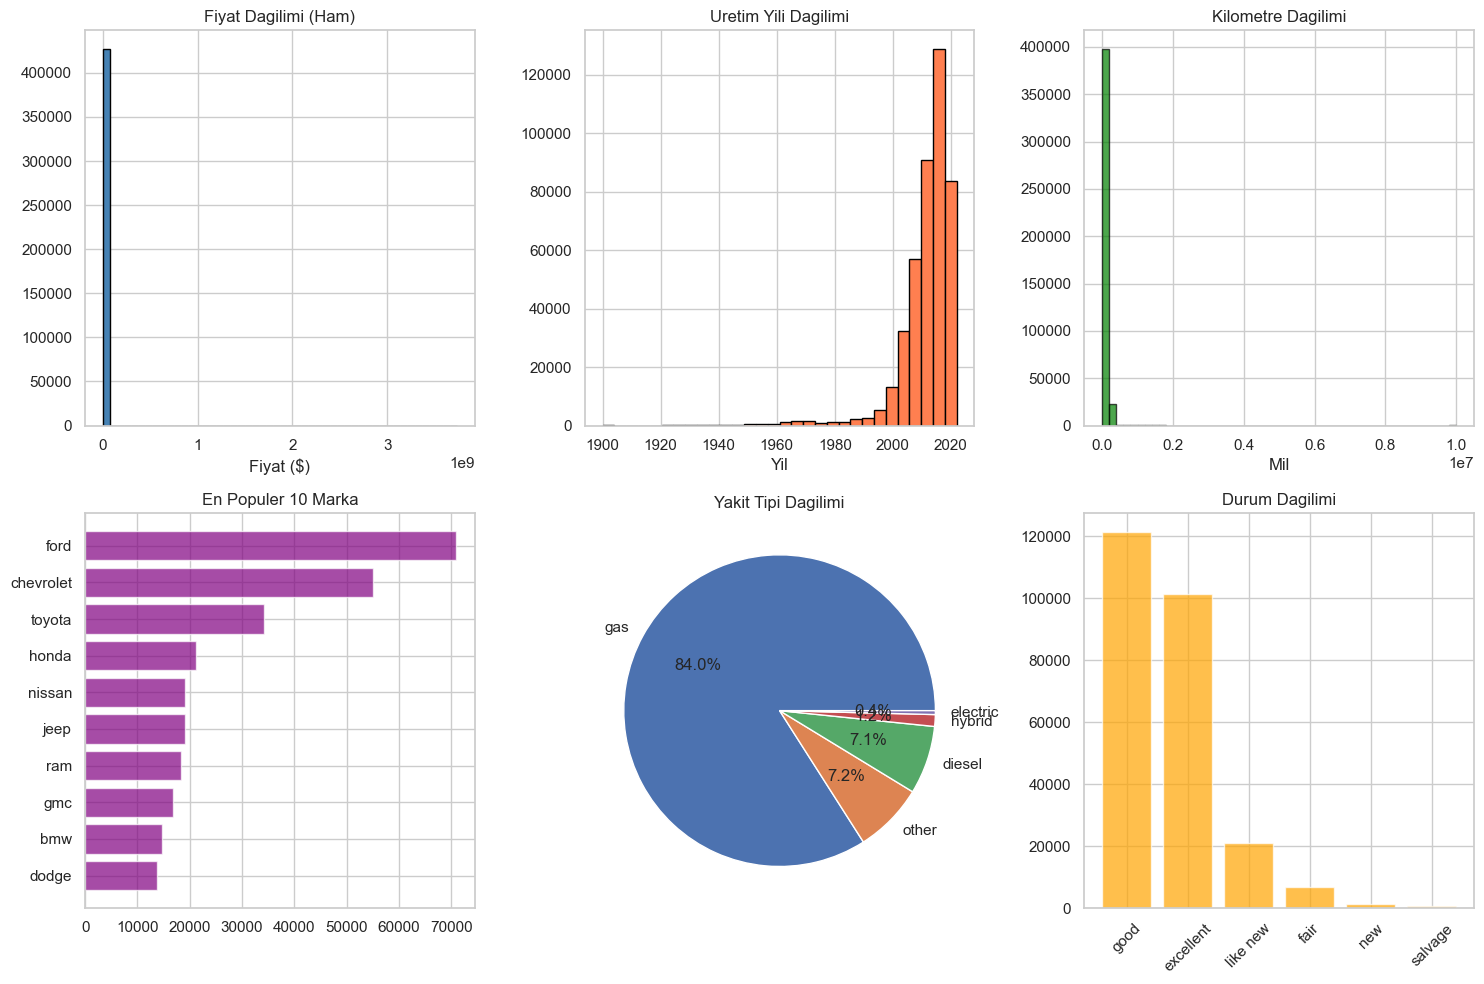

In [31]:
# EDA Grafikleri
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1) Fiyat dagilimi
axes[0,0].hist(df_raw['price'], bins=50, color='steelblue', edgecolor='black')
axes[0,0].set_title('Fiyat Dagilimi (Ham)')
axes[0,0].set_xlabel('Fiyat ($)')

# 2) Yil dagilimi
axes[0,1].hist(df_raw['year'].dropna(), bins=30, color='coral', edgecolor='black')
axes[0,1].set_title('Uretim Yili Dagilimi')
axes[0,1].set_xlabel('Yil')

# 3) Odometer dagilimi
axes[0,2].hist(df_raw['odometer'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0,2].set_title('Kilometre Dagilimi')
axes[0,2].set_xlabel('Mil')

# 4) Marka dagilimi (Top 10)
top_brands = df_raw['manufacturer'].value_counts().head(10)
axes[1,0].barh(top_brands.index, top_brands.values, color='purple', alpha=0.7)
axes[1,0].set_title('En Populer 10 Marka')
axes[1,0].invert_yaxis()

# 5) Yakit tipi dagilimi
fuel_counts = df_raw['fuel'].value_counts()
axes[1,1].pie(fuel_counts.values, labels=fuel_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Yakit Tipi Dagilimi')

# 6) Condition dagilimi
cond_counts = df_raw['condition'].value_counts()
axes[1,2].bar(cond_counts.index, cond_counts.values, color='orange', alpha=0.7)
axes[1,2].set_title('Durum Dagilimi')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3. Veri Temizleme


In [32]:
# Kullanilacak kolonlari sec
keep_cols = ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
             'odometer', 'title_status', 'transmission', 'drive', 'type', 'model', 'url']

df = df_raw[keep_cols].copy()

print('='*60)
print('VERI TEMIZLEME')
print('='*60)

# 1) Null degerleri temizle/doldur
initial_size = len(df)

# manufacturer kategorik -> unknown
df['manufacturer'] = df['manufacturer'].fillna('unknown')

# year: manufacturer median -> kalirsa global median
df['year'] = df['year'].fillna(df.groupby('manufacturer')['year'].transform('median'))
df['year'] = df['year'].fillna(df['year'].median())

# odometer: manufacturer median -> kalirsa global median
df['odometer'] = df['odometer'].fillna(df.groupby('manufacturer')['odometer'].transform('median'))
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

print(f'Null islemleri sonrasi: {len(df):,} ({initial_size - len(df):,} silindi)')

# 2) Fiyat outlierlarini temizle
df = df[(df['price'] >= 499) & (df['price'] <= 499999)]
print(f'Fiyat filtresi sonrasi (500-500K): {len(df):,}')

# 3) Yil filtresi (doldurma sonrasi da garanti)
df = df[df['year'] >= 1981]
print(f'Yil filtresi sonrasi (>=1981): {len(df):,}')

# 4) Odometer filtresi (doldurma sonrasi da garanti)
df = df[df['odometer'] <= 299999]
print(f'Odometer filtresi sonrasi (<=299999): {len(df):,}')


VERI TEMIZLEME
Null islemleri sonrasi: 426,880 (0 silindi)
Fiyat filtresi sonrasi (500-500K): 384,832
Yil filtresi sonrasi (>=1981): 376,565
Odometer filtresi sonrasi (<=299999): 373,919


In [33]:
# Kategorik degerlerdeki 'other' temizle
for col in ['cylinders', 'fuel', 'transmission']:
    if col in df.columns:
        df.loc[df[col].str.contains('other', case=False, na=False), col] = np.nan

# Cylinders numeric yap
df['cylinders'] = df['cylinders'].str.split().str[0]
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

# Eksik kategorik degerleri mod ile doldur
for col in ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']:
    if col in df.columns:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'unknown'
        df[col] = df[col].fillna(mode_val)

# Eksik numeric degerleri median ile doldur
for col in ['cylinders', 'odometer']:
    df[col] = df[col].fillna(df[col].median())

print(f'\nNull deger kontrolu:')
print(df.isnull().sum())


Null deger kontrolu:
price              0
year               0
manufacturer       0
condition          0
cylinders          0
fuel               0
odometer           0
title_status       0
transmission       0
drive              0
type               0
model           3683
url                0
dtype: int64


## 3.1 Feature Grafikleri (Veri Temizleme Sonrası)

Her bir feature'ın dağılımını ve fiyat ile ilişkisini görselleştiriyoruz.


NUMERIK FEATURE GRAFIKLERI


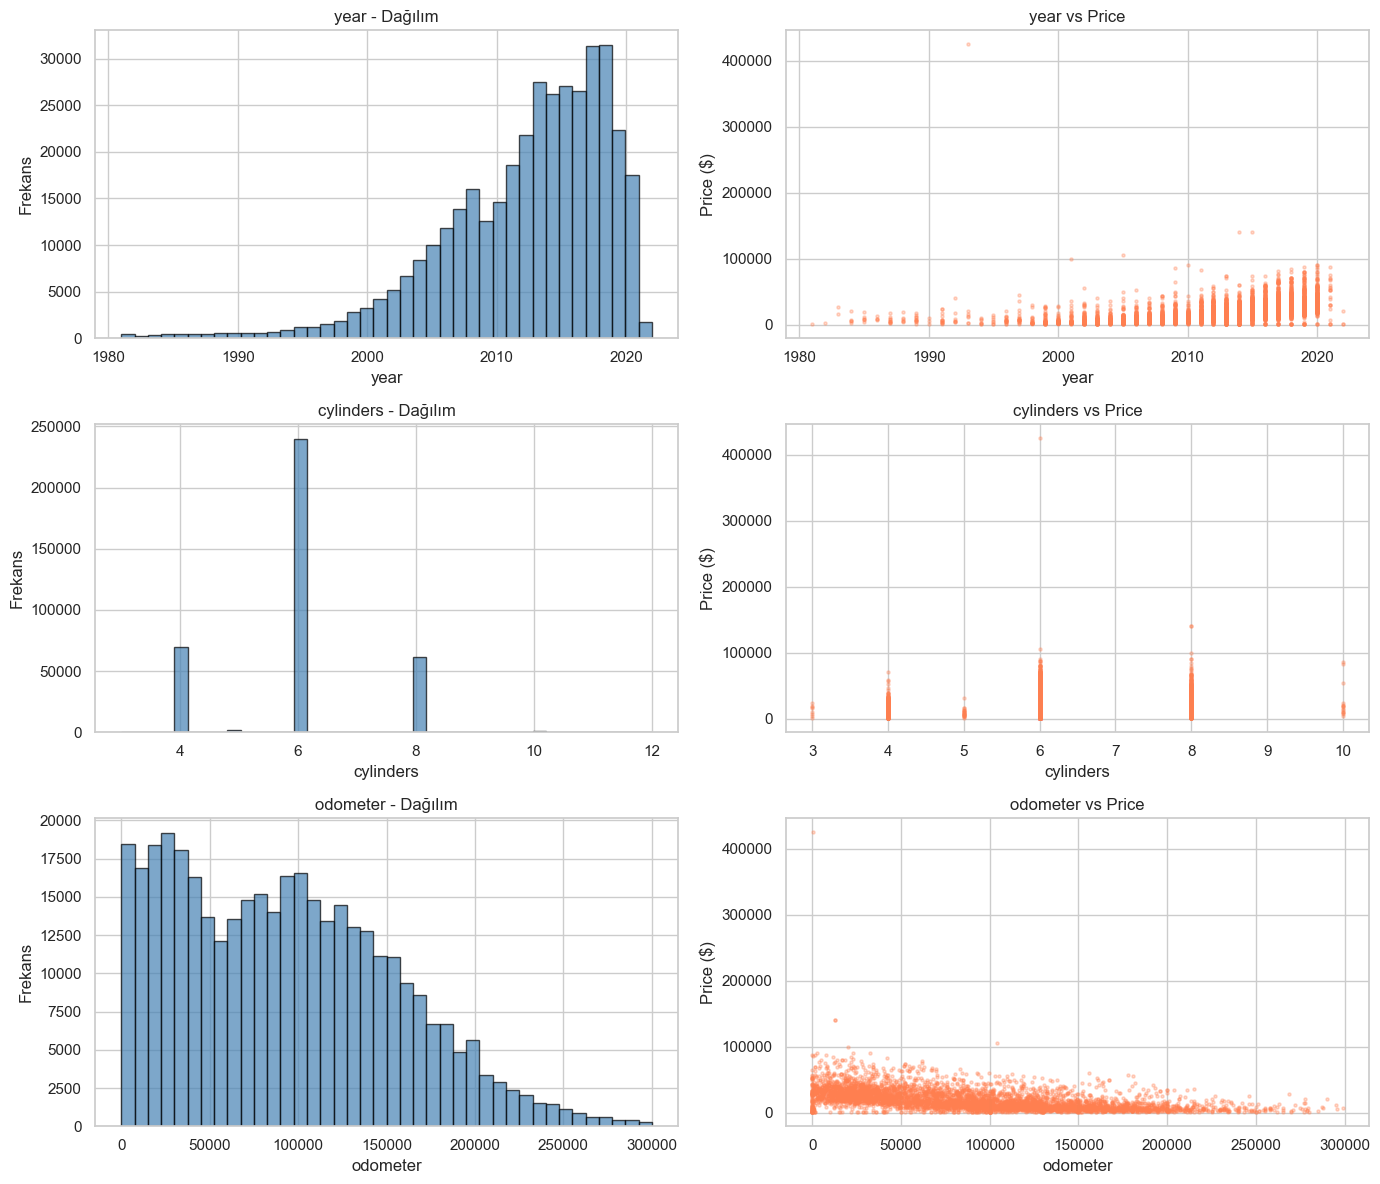

In [34]:
# NUMERIK FEATURE GRAFIKLERI
print('='*60)
print('NUMERIK FEATURE GRAFIKLERI')
print('='*60)

numeric_cols_analysis = ['year', 'cylinders', 'odometer']
fig, axes = plt.subplots(len(numeric_cols_analysis), 2, figsize=(14, 4*len(numeric_cols_analysis)))

for i, col in enumerate(numeric_cols_analysis):
    # Sol: Histogram
    axes[i, 0].hist(df[col].dropna(), bins=40, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'{col} - Dağılım')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frekans')
    
    # Sağ: Feature vs Price scatter
    sample = df.sample(min(5000, len(df)), random_state=42)
    axes[i, 1].scatter(sample[col], sample['price'], alpha=0.3, s=5, color='coral')
    axes[i, 1].set_title(f'{col} vs Price')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()


KATEGORIK FEATURE GRAFIKLERI - DAGILIM


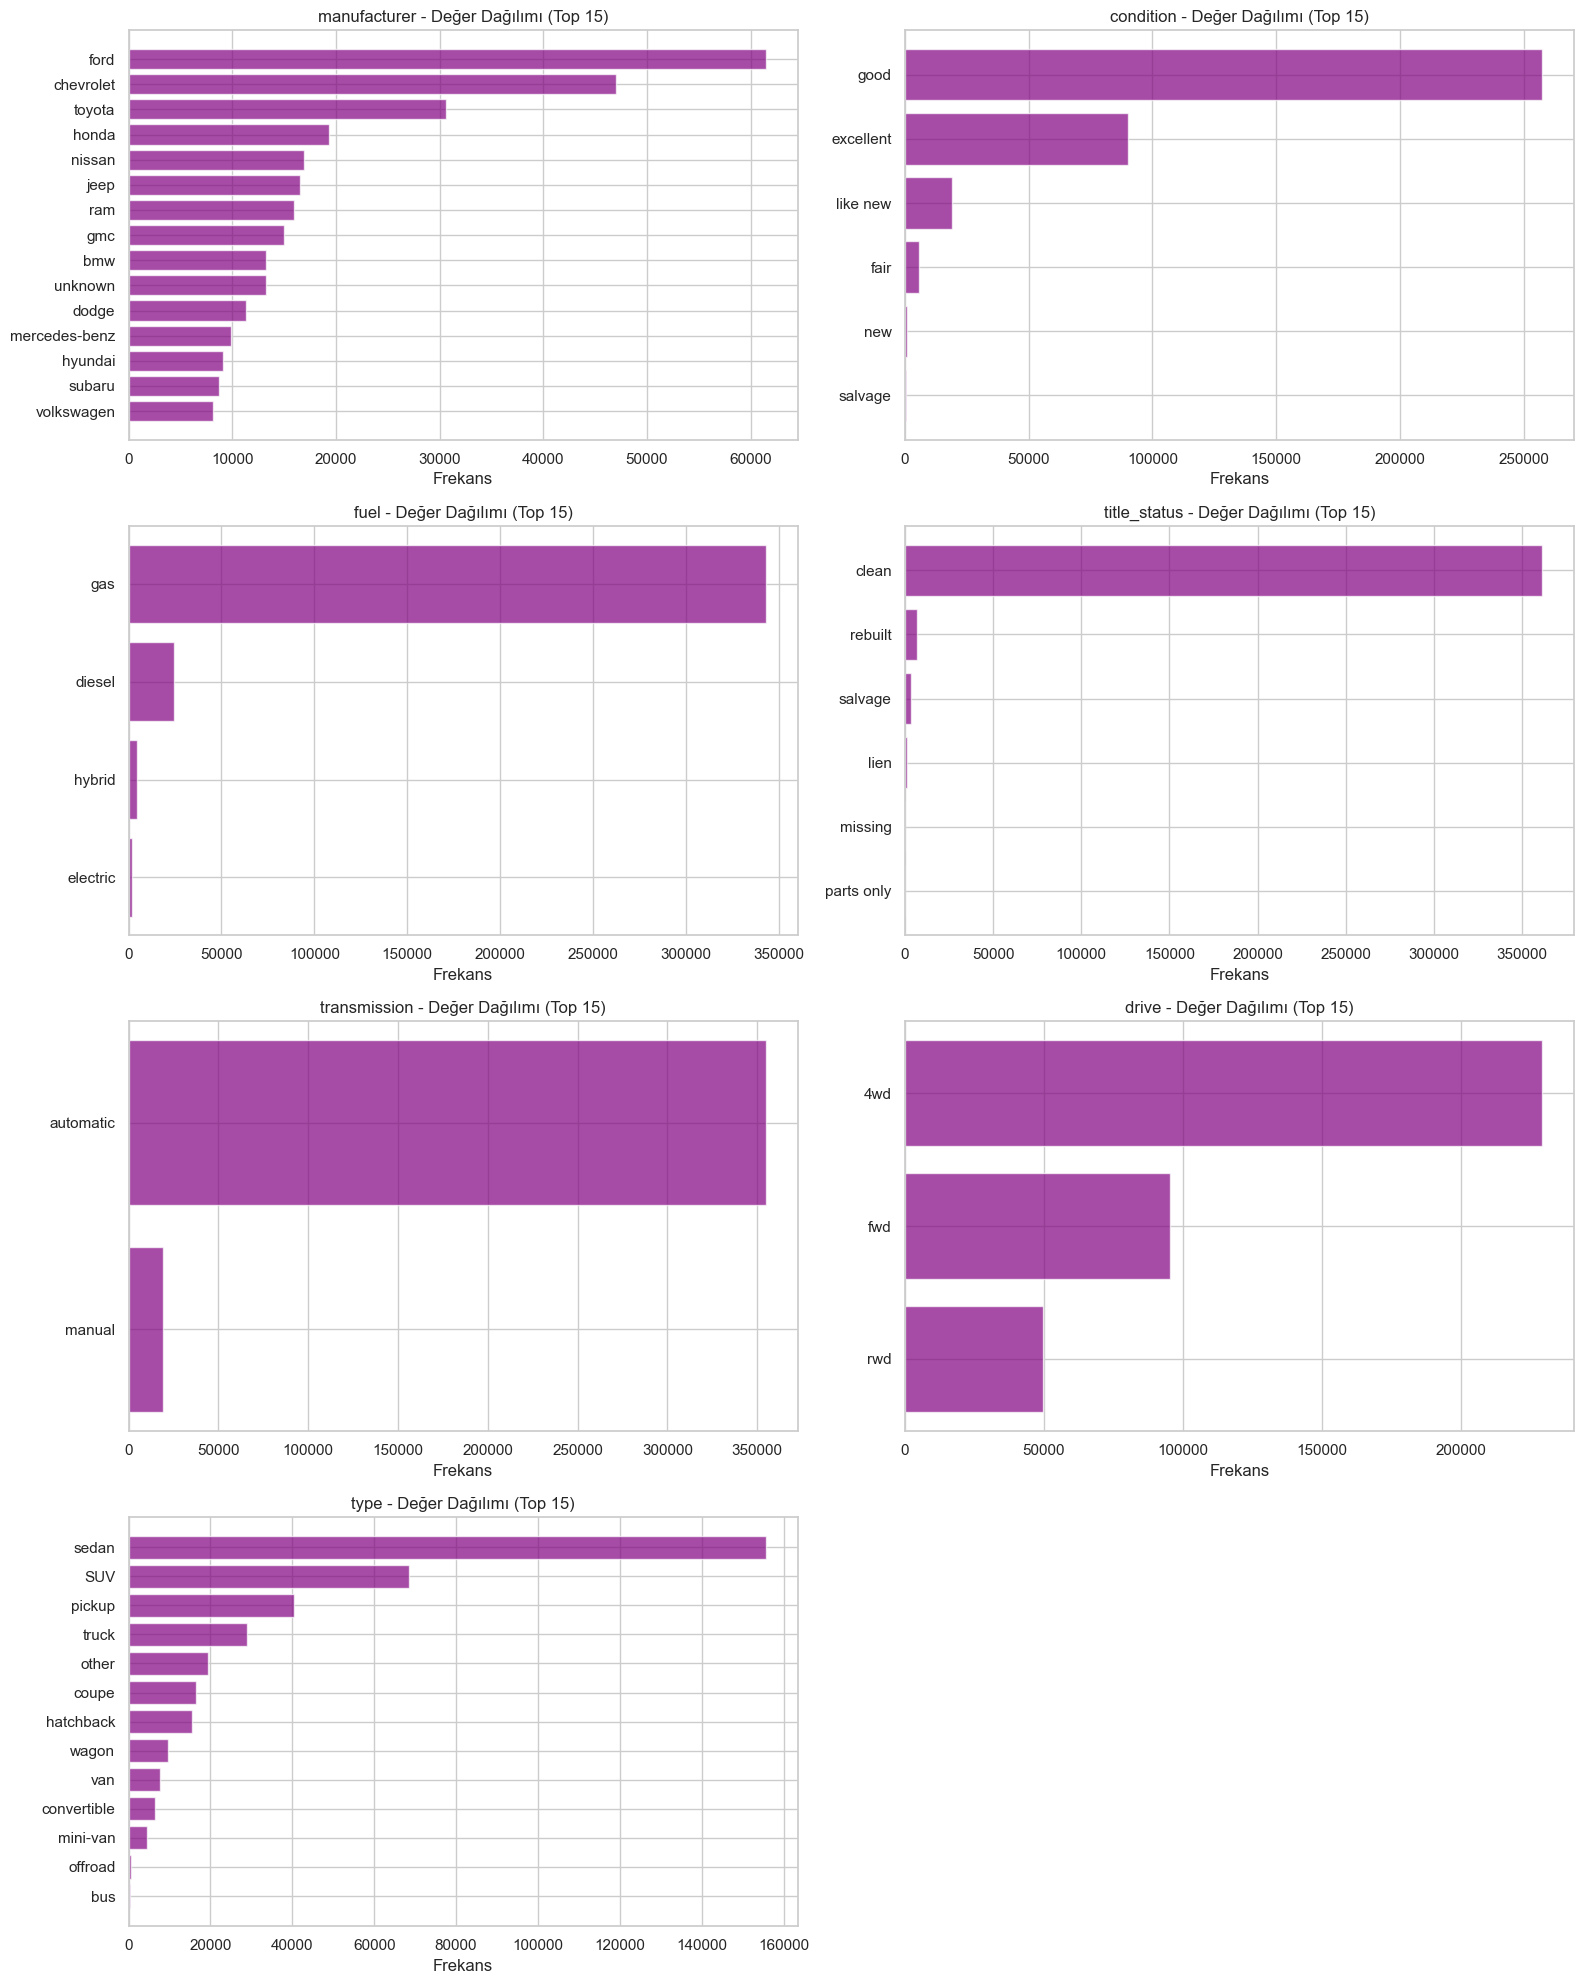

In [35]:
# KATEGORIK FEATURE GRAFIKLERI - SAYIM DAGILIMLARI
print('='*60)
print('KATEGORIK FEATURE GRAFIKLERI - DAGILIM')
print('='*60)

categorical_cols_analysis = ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols_analysis):
    value_counts = df[col].value_counts().head(15)  # Top 15
    axes[i].barh(value_counts.index, value_counts.values, color='purple', alpha=0.7)
    axes[i].set_title(f'{col} - Değer Dağılımı (Top 15)')
    axes[i].set_xlabel('Frekans')
    axes[i].invert_yaxis()

# Son boş subplot'u gizle
if len(categorical_cols_analysis) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


KATEGORIK FEATURE vs FIYAT (BOXPLOT)


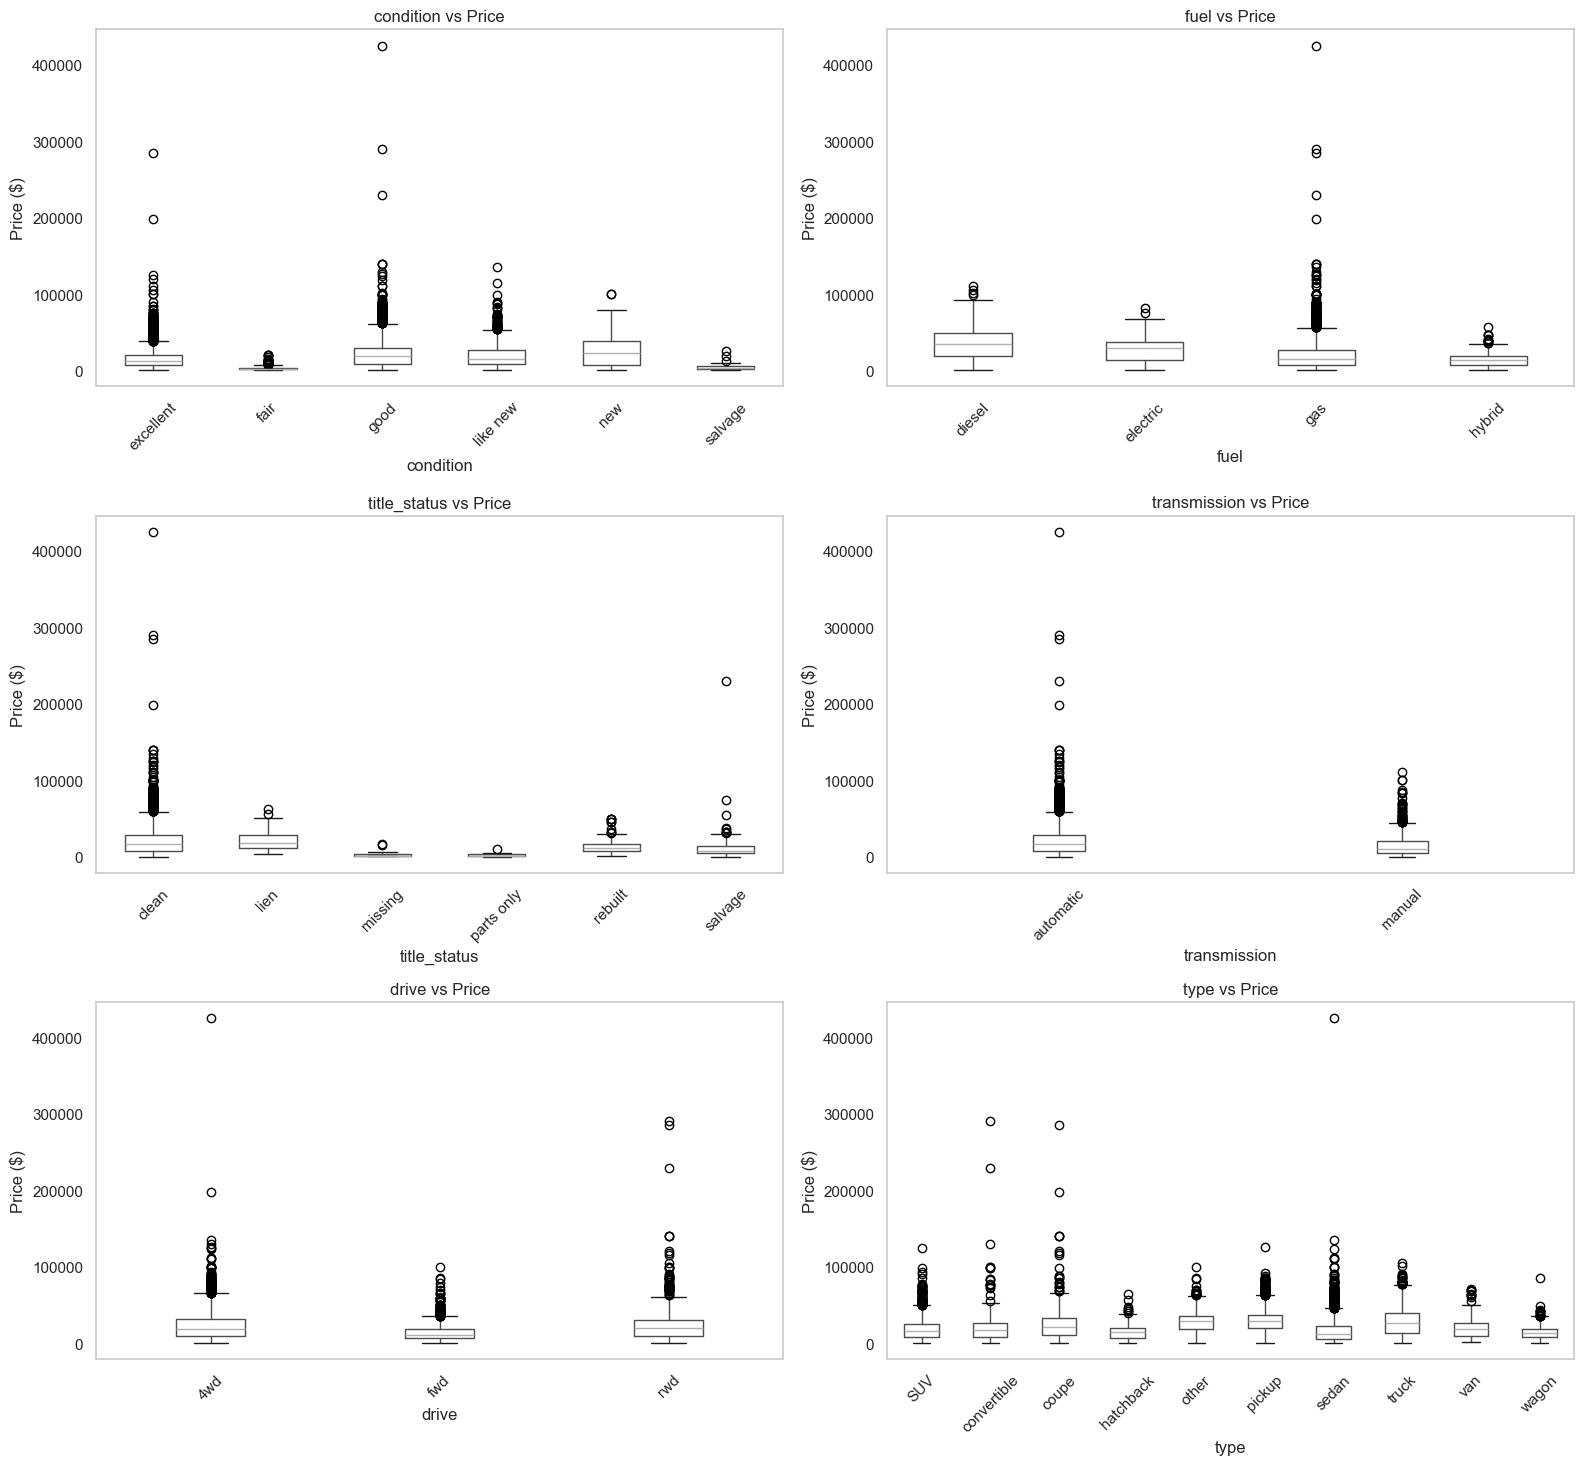

In [36]:
# KATEGORIK FEATURE vs FIYAT - BOXPLOT
print('='*60)
print('KATEGORIK FEATURE vs FIYAT (BOXPLOT)')
print('='*60)

# Daha az kategoriye sahip olanları boxplot için kullanalım
boxplot_cols = ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

# Örnekleme yapalım (görselleştirme için)
sample_df = df.sample(min(20000, len(df)), random_state=42)

for i, col in enumerate(boxplot_cols):
    # En yaygın 10 kategoriyi al
    top_categories = sample_df[col].value_counts().head(10).index.tolist()
    filtered_df = sample_df[sample_df[col].isin(top_categories)]
    
    # Boxplot
    filtered_df.boxplot(column='price', by=col, ax=axes[i], grid=False)
    axes[i].set_title(f'{col} vs Price')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price ($)')
    axes[i].tick_params(axis='x', rotation=45)
    plt.suptitle('')  # Ana başlığı kaldır

plt.tight_layout()
plt.show()


MANUFACTURER vs FIYAT (Top 15 Marka)


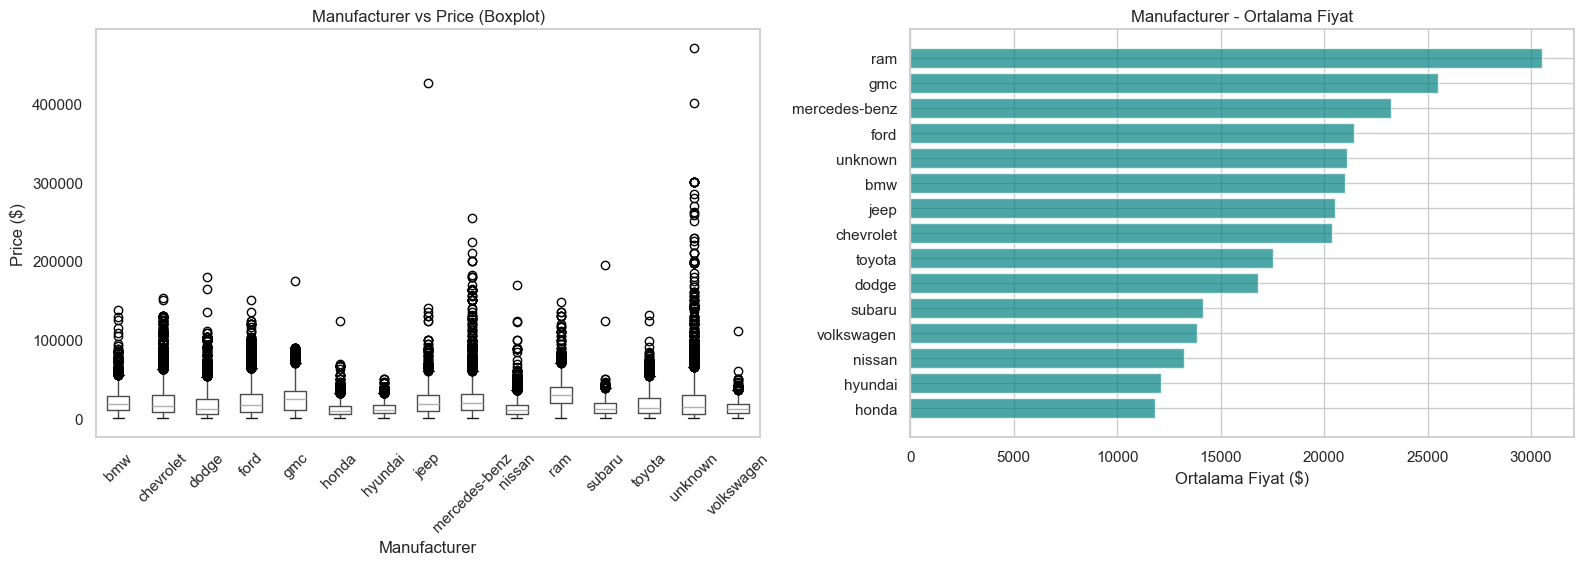

In [37]:
# MANUFACTURER vs FIYAT (Top 15 Marka)
print('='*60)
print('MANUFACTURER vs FIYAT (Top 15 Marka)')
print('='*60)

# Top 15 marka
top_manufacturers = df['manufacturer'].value_counts().head(15).index.tolist()
mfr_df = df[df['manufacturer'].isin(top_manufacturers)]

# Markaları ortalama fiyata göre sırala
mfr_order = mfr_df.groupby('manufacturer')['price'].median().sort_values(ascending=False).index

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sol: Boxplot
mfr_df.boxplot(column='price', by='manufacturer', ax=axes[0], grid=False, positions=range(len(top_manufacturers)))
axes[0].set_title('Manufacturer vs Price (Boxplot)')
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Price ($)')
axes[0].tick_params(axis='x', rotation=45)
plt.suptitle('')

# Sağ: Ortalama fiyat bar chart
avg_prices = mfr_df.groupby('manufacturer')['price'].mean().sort_values(ascending=True)
axes[1].barh(avg_prices.index, avg_prices.values, color='teal', alpha=0.7)
axes[1].set_title('Manufacturer - Ortalama Fiyat')
axes[1].set_xlabel('Ortalama Fiyat ($)')

plt.tight_layout()
plt.show()


## feature engineering 1 - url'den model çıkarma 

In [38]:
# 2.6 Model kolonu
print("="*80)
print("MODEL SÜTUNU ÖZETİ (NaN DAHİL)")
print("="*80)

# 1) Model'i temizle (küçük harf + strip, boşları None yap)
model_clean = (
    df['model']
      .astype(str)
      .str.lower()
      .str.strip()
      .replace({'nan': None, 'none': None, '': None})
)

# 2) NaN sayısı
nan_count = model_clean.isna().sum()
print(f"\n1) NaN (eksik) model sayısı: {nan_count:,}")

# 3) Farklı model sayısı (NaN hariç)
unique_models = model_clean.dropna().unique()
print(f"\n2) Farklı (distinct) model sayısı (NaN hariç): {len(unique_models):,}")

# 4) Frekansa göre en sık geçen ilk 25 model
print("\n3) En sık geçen ilk 25 model:")
print(
    model_clean.value_counts(dropna=True)
               .head(50)
               .to_string()
)

# 5) Tüm farklı modellere alfabetik bakmak istersen (konsolu boğmadan ilk 50'ü göster)
unique_models_sorted = sorted(unique_models)

print("\n4) Alfabetik model listesi (ilk 25):")
for m in unique_models_sorted[:25]:
    print(m)

MODEL SÜTUNU ÖZETİ (NaN DAHİL)

1) NaN (eksik) model sayısı: 3,683

2) Farklı (distinct) model sayısı (NaN hariç): 24,452

3) En sık geçen ilk 25 model:
model
f-150                 6973
silverado 1500        4402
1500                  3691
camry                 2733
silverado             2649
accord                2634
civic                 2506
wrangler              2475
escape                2463
altima                2401
2500                  2357
tacoma                2321
explorer              2206
grand cherokee        2174
corolla               1934
mustang               1754
equinox               1716
cr-v                  1686
focus                 1636
fusion                1609
grand caravan         1520
rav4                  1492
malibu                1492
tahoe                 1470
odyssey               1438
sonata                1434
outback               1425
sierra 1500           1403
corvette              1388
impala                1376
silverado 2500hd      1359
cruz

In [39]:
# 2.6.1 - MODEL SÖZLÜĞÜ

print("="*80)
print("CELL 2.6.1 - MODEL SÖZLÜĞÜ")
print("="*80)

models_by_brand = {
    'ford': [
        'f-150', 'f-250', 'f-350', 'mustang', 'explorer', 'escape', 'focus', 'fusion',
        'edge', 'expedition', 'ranger', 'taurus', 'fiesta', 'flex', 'bronco',
        'ecosport', 'transit', 'c-max', 'crown victoria', 'thunderbird', 'excursion',
        'freestar', 'windstar', 'contour', 'probe', 'aspire', 'aerostar', 'gt',
        'bronco sport'
    ],
    'chevrolet': [
        'silverado 1500', 'silverado 2500', 'silverado 3500', 'camaro', 'corvette',
        'malibu', 'equinox', 'tahoe', 'suburban', 'traverse', 'impala', 'cruze',
        'blazer', 'colorado', 'trax', 'sonic', 'spark', 'volt', 'bolt', 'avalanche',
        'trailblazer', 'ssr', 'hhr', 'cobalt', 'cavalier', 'monte carlo', 's-10',
        'astro', 'express', 'venture', 'uplander'
    ],
    'toyota': [
        'camry', 'corolla', 'rav4', 'tacoma', 'tundra', '4runner', 'highlander',
        'prius', 'sienna', 'avalon', 'sequoia', 'land cruiser', 'yaris', 'matrix',
        'venza', 'fj cruiser', 'c-hr', 'supra', '86', 'celica', 'mr2', 'echo',
        'solara', 'previa', 't100'
    ],
    'honda': [
        'civic', 'accord', 'cr-v', 'pilot', 'odyssey', 'fit', 'hr-v', 'ridgeline',
        'passport', 'element', 'insight', 'cr-z', 's2000', 'prelude', 'del sol',
        'crosstour'
    ],
    'nissan': [
        'altima', 'sentra', 'rogue', 'maxima', 'pathfinder', 'frontier', 'titan',
        'murano', 'versa', 'juke', 'armada', 'leaf', '370z', '350z', '300zx',
        'quest', 'xterra', 'kicks', 'cube', 'gt-r', '240sx', 'stanza', 'pulsar', 'nx'
    ],
    'jeep': [
        'wrangler', 'grand cherokee', 'cherokee', 'compass', 'renegade', 'gladiator',
        'patriot', 'liberty', 'commander', 'wagoneer', 'grand wagoneer'
    ],
    'ram': [
        '1500', '2500', '3500', 'promaster', 'dakota'
    ],
    'gmc': [
        'sierra 1500', 'sierra 2500', 'sierra 3500', 'yukon', 'yukon xl', 'acadia',
        'terrain', 'canyon', 'savana', 'envoy', 'jimmy', 'sonoma', 'safari',
        'syclone', 'typhoon'
    ],
    'bmw': [
        '3 series', '5 series', '7 series', 'x3', 'x5', 'x1', 'x6', '2 series',
        '4 series', '6 series', '8 series', 'x2', 'x4', 'x7', 'z3', 'z4', 'm3',
        'm5', 'i3', 'i8', '1 series'
    ],
    'dodge': [
        'charger', 'challenger', 'durango', 'journey', 'grand caravan', 'dart',
        'avenger', 'caliber', 'neon', 'stratus', 'intrepid', 'dakota', 'ram',
        'viper', 'magnum', 'nitro', 'caravan', 'spirit', 'shadow', 'stealth'
    ],
    'mercedes-benz': [
        'c-class', 'e-class', 's-class', 'gle', 'glc', 'gla', 'glb', 'gls', 'cla',
        'a-class', 'b-class', 'g-class', 'sl-class', 'slk-class', 'cls-class',
        'ml-class', 'gl-class', 'glk-class', 'r-class', 'sprinter', 'metris'
    ],
    'hyundai': [
        'elantra', 'sonata', 'tucson', 'santa fe', 'accent', 'kona', 'palisade',
        'veloster', 'genesis', 'azera', 'venue', 'ioniq', 'tiburon', 'excel',
        'scoupe', 'entourage'
    ],
    'subaru': [
        'outback', 'forester', 'impreza', 'legacy', 'crosstrek', 'ascent', 'wrx',
        'brz', 'baja', 'tribeca', 'svx'
    ],
    'volkswagen': [
        'jetta', 'passat', 'tiguan', 'atlas', 'golf', 'beetle', 'gti', 'touareg',
        'arteon', 'cc', 'eos', 'cabrio', 'rabbit', 'routan', 'phaeton', 'corrado',
        'eurovan'
    ],
    'kia': [
        'soul', 'optima', 'sorento', 'sportage', 'forte', 'telluride', 'sedona',
        'rio', 'stinger', 'niro', 'seltos', 'k5', 'cadenza', 'amanti', 'spectra',
        'sephia', 'rondo'
    ],
    'lexus': [
        'es', 'rx', 'is', 'gx', 'nx', 'ux', 'ls', 'lx', 'gs', 'rc', 'lc', 'ct',
        'hs', 'sc', 'lfa'
    ],
    'audi': [
        'a4', 'a6', 'q5', 'q7', 'a3', 'q3', 'a5', 'a8', 'q8', 'tt', 'r8', 's4',
        's5', 's6', 'rs5', 'rs7', 'e-tron', 'allroad', 'a7'
    ],
    'cadillac': [
        'escalade', 'xt5', 'ct6', 'cts', 'ats', 'srx', 'xt4', 'xts', 'dts', 'sts',
        'deville', 'eldorado', 'catera', 'xlr', 'elr', 'ct4', 'ct5'
    ],
    'chrysler': [
        '300', 'pacifica', '200', 'town & country', 'town and country', 'town country',
        'sebring', 'concorde', 'lhs', 'crossfire', 'pt cruiser', 'cirrus', 'aspen',
        'voyager'
    ],
    'acura': [
        'mdx', 'tlx', 'rdx', 'ilx', 'nsx', 'tsx', 'tl', 'rl', 'rsx', 'integra',
        'legend', 'vigor', 'cl', 'zdx', 'rlx'
    ],
    'buick': [
        'enclave', 'encore', 'envision', 'lacrosse', 'regal', 'lucerne', 'lesabre',
        'century', 'park avenue', 'rendezvous', 'rainier', 'terraza', 'riviera',
        'roadmaster'
    ],
    'mazda': [
        'mazda3', 'mazda6', 'cx-5', 'cx-9', 'cx-3', 'cx-30', 'mx-5 miata', 'cx-7',
        'tribute', 'mpv', 'protege', '626', 'millenia', 'rx-7', 'rx-8', 'b-series'
    ],
    'infiniti': [
        'q50', 'q60', 'qx60', 'qx80', 'qx50', 'qx30', 'g35', 'g37', 'm35', 'm37',
        'fx35', 'fx45', 'ex35', 'jx35', 'qx4', 'i30', 'i35', 'q45'
    ],
    'lincoln': [
        'navigator', 'aviator', 'nautilus', 'corsair', 'continental', 'mkz',
        'mkx', 'mkc', 'mks', 'mkt', 'town car', 'ls', 'zephyr', 'mark lt',
        'blackwood'
    ],
    'volvo': [
        'xc90', 'xc60', 's60', 's90', 'v60', 'v90', 'xc40', 'xc70', 's40', 'v50',
        'v70', 'c30', 'c70', '240', '850', '940', '960'
    ],
    'mitsubishi': [
        'outlander', 'eclipse', 'lancer', 'mirage', 'outlander sport', 'montero',
        'galant', 'diamante', '3000gt', 'eclipse cross', 'endeavor', 'raider'
    ],
    'mini': [
        'cooper', 'countryman', 'clubman', 'paceman', 'coupe', 'roadster', 'convertible'
    ],
    'pontiac': [
        'grand prix', 'grand am', 'g6', 'g5', 'vibe', 'sunfire', 'bonneville',
        'firebird', 'trans am', 'aztek', 'montana', 'torrent', 'solstice', 'gto',
        'fiero'
    ],
    'rover': [
        '75', '45', '25', '200', '400', '600', '800', 'metro', 'mini', 'range rover'
    ],
    'jaguar': [
        'f-pace', 'e-pace', 'i-pace', 'xf', 'xe', 'xj', 'f-type', 'x-type',
        's-type', 'xk', 'xjs', 'xjr'
    ],
    'porsche': [
        '911', 'cayenne', 'macan', 'panamera', 'boxster', 'cayman', '718',
        'taycan', '944', '928', '968'
    ],
    'mercury': [
        'grand marquis', 'sable', 'mountaineer', 'mariner', 'milan', 'montego',
        'cougar', 'mystique', 'villager', 'tracer', 'topaz'
    ],
    'saturn': [
        'vue', 'ion', 'outlook', 'aura', 'sky', 'l-series', 's-series', 'relay'
    ],
    'alfa-romeo': [
        'giulia', 'stelvio', '4c', 'spider', '164', '156', '147', 'gtv', 'brera'
    ],
    'tesla': [
        'model s', 'model 3', 'model x', 'model y', 'roadster', 'cybertruck'
    ],
    'fiat': [
        '500', '500l', '500x', '124 spider', 'panda', 'punto', 'bravo', 'ducato'
    ],
    'harley-davidson': [
        'sportster', 'softail', 'touring', 'street', 'v-rod', 'dyna'
    ],
    'ferrari': [
        '488', 'f8', '812', 'roma', 'portofino', 'sf90', '458', 'california',
        '599', '612', 'f12', 'laferrari', 'enzo', '360', '550', '575', 'testarossa'
    ],
    'datsun': [
        '280z', '240z', '260z', '510', '620', '720', 'b210', '200sx'
    ],
    'aston-martin': [
        'db9', 'db11', 'dbs', 'vantage', 'rapide', 'vanquish', 'virage',
        'v8 vantage', 'dbx'
    ],
    'land rover': [
        'range rover', 'range rover sport', 'range rover evoque', 'discovery',
        'defender', 'lr2', 'lr3', 'lr4', 'freelander'
    ],
    'morgan': [
        'plus 4', 'plus 6', '4/4', 'roadster', 'aero', '3 wheeler'
    ],
}

print(f"Toplam marka sayısı: {len(models_by_brand)}")
print(f"Toplam model sayısı: {sum(len(v) for v in models_by_brand.values())}")

CELL 2.6.1 - MODEL SÖZLÜĞÜ
Toplam marka sayısı: 42
Toplam model sayısı: 603


In [40]:
# 2.6.2 - MODEL VARYANTLARI

import re

print("="*80)
print("CELL 2.6.2 - MODEL VARYANTLARI")
print("="*80)

def generate_model_variants(model_name):
    """Bir model ismi için tüm olası varyasyonları üretir."""
    variants = set()
    variants.add(model_name.lower().strip())
    
    if '-' in model_name:
        variants.add(model_name.replace('-', ''))
        variants.add(model_name.replace('-', ' '))
    
    if ' ' in model_name:
        variants.add(model_name.replace(' ', '-'))
        variants.add(model_name.replace(' ', ''))
    
    matches = re.findall(r'([a-z]+)(\d+)', model_name.replace('-', '').replace(' ', ''))
    if matches:
        for letter, number in matches:
            variants.add(f"{letter}-{number}")
            variants.add(f"{letter} {number}")
    
    return list(variants)

# Varyantları içeren genişletilmiş set
all_known_models = set()
all_model_variants = {}

for brand, models in models_by_brand.items():
    for model_name in models:
        variants = generate_model_variants(model_name)
        for variant in variants:
            all_known_models.add(variant.lower())
            all_model_variants[variant.lower()] = model_name.lower()

# Orijinal modeller seti
all_known_models = set()
for brand, models in models_by_brand.items():
    for m in models:
        all_known_models.add(m.lower())

print(f"Toplam bilinen model sayısı: {len(all_known_models)}")

CELL 2.6.2 - MODEL VARYANTLARI
Toplam bilinen model sayısı: 596


In [41]:
# 2.6.3 - URL İŞLEME FONKSİYONLARI

import re
import pandas as pd

print("="*80)
print("CELL 2.6.3 - URL İŞLEME FONKSİYONLARI")
print("="*80)

def normalize_url_to_tokens(url):
    """URL'yi normalize edip token listesi döndürür."""
    u = str(url).lower().strip()
    if '://' in u:
        u = u.split('://', 1)[1]
    if '/' in u:
        u = u.split('/', 1)[1]

    u = u.replace('%20', ' ')
    for ch in ['-', '_', '/', '.', ',', ';']:
        u = u.replace(ch, ' ')
    u = re.sub(r'\s+', ' ', u).strip()
    if not u:
        return []
    return u.split(' ')


def model_tokens(model_name):
    """Model ismini token listesine çevirir."""
    m = str(model_name).lower().strip()
    m = m.replace('%20', ' ')
    for ch in ['-', '_', '/', '.', ',', ';']:
        m = m.replace(ch, ' ')
    m = re.sub(r'\s+', ' ', m).strip()
    if not m:
        return []
    return m.split(' ')


def contains_model(tokens, model_name):
    """URL token listesi içinde model ardışık olarak geçiyor mu?"""
    mtoks = model_tokens(model_name)
    if not mtoks:
        return False
    n, k = len(tokens), len(mtoks)
    if k == 0 or n < k:
        return False
    for i in range(n - k + 1):
        if tokens[i:i+k] == mtoks:
            return True
    return False


def extract_model_from_url_with_dict(url, manufacturer):
    """URL içinde manufacturer'a göre model bulur."""
    if pd.isna(url) or pd.isna(manufacturer):
        return None

    manu = str(manufacturer).lower().strip()
    model_list = models_by_brand.get(manu)
    if not model_list:
        return None

    tokens = normalize_url_to_tokens(url)

    sorted_models = sorted(
        model_list,
        key=lambda m: (-len(model_tokens(m)), -len(m), m)
    )

    for model_name in sorted_models:
        if contains_model(tokens, model_name):
            return model_name.lower()

    return None

print("URL işleme fonksiyonları tanımlandı.")

CELL 2.6.3 - URL İŞLEME FONKSİYONLARI
URL işleme fonksiyonları tanımlandı.


In [42]:
# 2.6 – MODEL SÜTUNU TEMİZLEME (GÜNCEL)

import re

print("="*80)
print("CELL 2 - MODEL SÜTUNU TEMİZLEME")
print("="*80)

# 1) Sadece basic temizlik yap
df['model_clean'] = (
    df['model']
      .astype(str)
      .str.lower()
      .str.strip()
      .replace({'nan': None, 'none': None, '': None})
)

print(f"Ham model NaN sayısı: {df['model_clean'].isna().sum():,}")

# 2) Normalizasyon: tire/boşluk/bitişik varyantlarını standartlaştır
def normalize_model_variants(s):
    """Model ismini normalize et (tire/boşluk varyantlarını birleştir)"""
    if pd.isna(s):
        return None
    
    t = str(s).lower().strip()
    
    # Gereksiz karakterleri temizle
    t = re.sub(r'[^a-z0-9\s\-]', '', t)
    t = re.sub(r'\s+', ' ', t).strip()
    
    if not t:
        return None
    
    # all_model_variants sözlüğünde varsa canonical halini al
    if t in all_model_variants:
        return all_model_variants[t]
    
    return t

df['model_normalized'] = df['model_clean'].apply(normalize_model_variants)

print(f"Normalize edilmiş model sayısı: {df['model_normalized'].notna().sum():,}")

# 3) ⚠️ KRİTİK: SÖZLÜKTE OLMAYANLARI SİL
mask_not_in_dict = (
    df['model_normalized'].notna() & 
    (~df['model_normalized'].isin(all_known_models))
)

silinen_count = mask_not_in_dict.sum()
print(f"\n⚠️ SÖZLÜKTE OLMAYAN VE SİLİNEN model sayısı: {silinen_count:,}")

# Sözlükte olmayanları None yap
df.loc[mask_not_in_dict, 'model_normalized'] = None

nan_after = df['model_normalized'].isna().sum()
dolu_after = df['model_normalized'].notna().sum()

print(f"\nTemizlik SONRASI:")
print(f"   model_normalized NaN: {nan_after:,} ({nan_after/len(df)*100:.2f}%)")
print(f"   model_normalized dolu: {dolu_after:,} ({dolu_after/len(df)*100:.2f}%)")
print(f"   Farklı model sayısı: {df['model_normalized'].nunique(dropna=True):,}")

print("\nEn sık geçen 30 model:")
print(df['model_normalized'].value_counts(dropna=True).head(30).to_string())

print("\nCell 2 tamamlandı.")

CELL 2 - MODEL SÜTUNU TEMİZLEME
Ham model NaN sayısı: 3,683
Normalize edilmiş model sayısı: 370,227

⚠️ SÖZLÜKTE OLMAYAN VE SİLİNEN model sayısı: 210,696

Temizlik SONRASI:
   model_normalized NaN: 214,388 (57.34%)
   model_normalized dolu: 159,531 (42.66%)
   Farklı model sayısı: 531

En sık geçen 30 model:
model_normalized
f-150             8016
silverado 1500    4403
1500              3692
camry             2733
accord            2635
civic             2506
wrangler          2475
escape            2463
altima            2404
2500              2357
tacoma            2321
explorer          2206
grand cherokee    2181
f-250             1970
corolla           1935
cr-v              1934
mustang           1754
equinox           1717
focus             1636
fusion            1609
rav4              1541
grand caravan     1520
malibu            1492
tahoe             1470
odyssey           1438
sonata            1434
outback           1425
sierra 1500       1403
f-350             1392
corvet

In [43]:
# URL'DEN MODEL ÇIKARTMA VE DOLDURMA

print("="*80)
print(" URL'DEN MODEL ÇIKARTMA")
print("="*80)

def extract_model_from_url_with_variants(url, manufacturer):
    """URL'den model çıkartır, tüm varyantları kontrol eder."""
    if pd.isna(url) or pd.isna(manufacturer):
        return None

    manu = str(manufacturer).lower().strip()
    model_list = models_by_brand.get(manu)
    if not model_list:
        return None

    tokens = normalize_url_to_tokens(url)
    
    # Her model için tüm varyantları kontrol et
    for model_name in model_list:
        variants = generate_model_variants(model_name)
        
        for variant in variants:
            if contains_model(tokens, variant):
                # Canonical (standart) halini döndür
                return model_name.lower()
    
    return None

# URL'den model çıkar
df['model_from_url'] = df.apply(
    lambda row: extract_model_from_url_with_variants(row['url'], row['manufacturer']),
    axis=1
)

found_count = df['model_from_url'].notna().sum()
print(f"\n1) URL'den bulunan model sayısı: {found_count:,} ({found_count / len(df) * 100:.2f}%)")

# ⚠️ ŞİMDİ BOŞ OLAN SATIRLARI URL'DEN DOLDUR
mask_empty = df['model_normalized'].isna()
mask_has_url_model = df['model_from_url'].notna()
mask_to_fill = mask_empty & mask_has_url_model

doldurulan = mask_to_fill.sum()
print(f"\n2) Boş satırlarda URL'den doldurulan model sayısı: {doldurulan:,}")

df.loc[mask_to_fill, 'model_normalized'] = df.loc[mask_to_fill, 'model_from_url']

# Final durum
nan_final = df['model_normalized'].isna().sum()
dolu_final = df['model_normalized'].notna().sum()

print(f"\n3) DOLDURMA SONRASI:")
print(f"   model_normalized NaN: {nan_final:,} ({nan_final/len(df)*100:.2f}%)")
print(f"   model_normalized dolu: {dolu_final:,} ({dolu_final/len(df)*100:.2f}%)")

print("\nEn sık 30 model (URL doldurma sonrası):")
print(df['model_normalized'].value_counts(dropna=True).head(30).to_string())

print("\nCell 4 tamamlandı.")

 URL'DEN MODEL ÇIKARTMA

1) URL'den bulunan model sayısı: 276,265 (73.88%)

2) Boş satırlarda URL'den doldurulan model sayısı: 145,034

3) DOLDURMA SONRASI:
   model_normalized NaN: 69,354 (18.55%)
   model_normalized dolu: 304,565 (81.45%)

En sık 30 model (URL doldurma sonrası):
model_normalized
f-150             12138
1500               8338
wrangler           7100
silverado 1500     5401
tacoma             5249
civic              5154
accord             4775
camry              4493
f-250              4018
sierra 1500        4004
escape             3859
2500               3842
mustang            3521
explorer           3473
altima             3459
grand cherokee     3430
tundra             3182
corolla            3050
focus              3029
fusion             2852
equinox            2725
f-350              2692
sonata             2679
tahoe              2491
cruze              2477
cr-v               2404
jetta              2400
prius              2377
corvette           2373
4runn

In [44]:
# FİNAL ÖZET

print("="*80)
print("MODEL SÜTUNU FİNAL ÖZETİ")
print("="*80)

total = len(df)
nan_count = df['model_normalized'].isna().sum()
dolu_count = df['model_normalized'].notna().sum()
distinct = df['model_normalized'].nunique(dropna=True)

print(f"\nToplam satır: {total:,}")
print(f"model_normalized dolu: {dolu_count:,} ({dolu_count/total*100:.2f}%)")
print(f"model_normalized NaN: {nan_count:,} ({nan_count/total*100:.2f}%)")
print(f"Farklı model sayısı: {distinct}")


print("\nEn sık 25 model:")
print(df['model_normalized'].value_counts(dropna=True).head(25).to_string())

MODEL SÜTUNU FİNAL ÖZETİ

Toplam satır: 373,919
model_normalized dolu: 304,565 (81.45%)
model_normalized NaN: 69,354 (18.55%)
Farklı model sayısı: 546

En sık 25 model:
model_normalized
f-150             12138
1500               8338
wrangler           7100
silverado 1500     5401
tacoma             5249
civic              5154
accord             4775
camry              4493
f-250              4018
sierra 1500        4004
escape             3859
2500               3842
mustang            3521
explorer           3473
altima             3459
grand cherokee     3430
tundra             3182
corolla            3050
focus              3029
fusion             2852
equinox            2725
f-350              2692
sonata             2679
tahoe              2491
cruze              2477


In [45]:
df['model_normalized'] = df['model_normalized'].fillna('unknown')
print(f"Boş modeller 'unknown' olarak işaretlendi.")

# kontrol amaçlı
unique_models = sorted(df['model_normalized'].dropna().unique())
unique_models[:35]


Boş modeller 'unknown' olarak işaretlendi.


['1 series',
 '124 spider',
 '1500',
 '2 series',
 '200',
 '240',
 '240sx',
 '2500',
 '3 series',
 '300',
 '3000gt',
 '300zx',
 '3500',
 '350z',
 '360',
 '370z',
 '4 series',
 '400',
 '458',
 '488',
 '4runner',
 '5 series',
 '500',
 '500l',
 '500x',
 '550',
 '575',
 '6 series',
 '600',
 '620',
 '626',
 '7 series',
 '718',
 '720',
 '75']

MODEL DAĞILIMI (URL'den Çıkarma Sonrası)


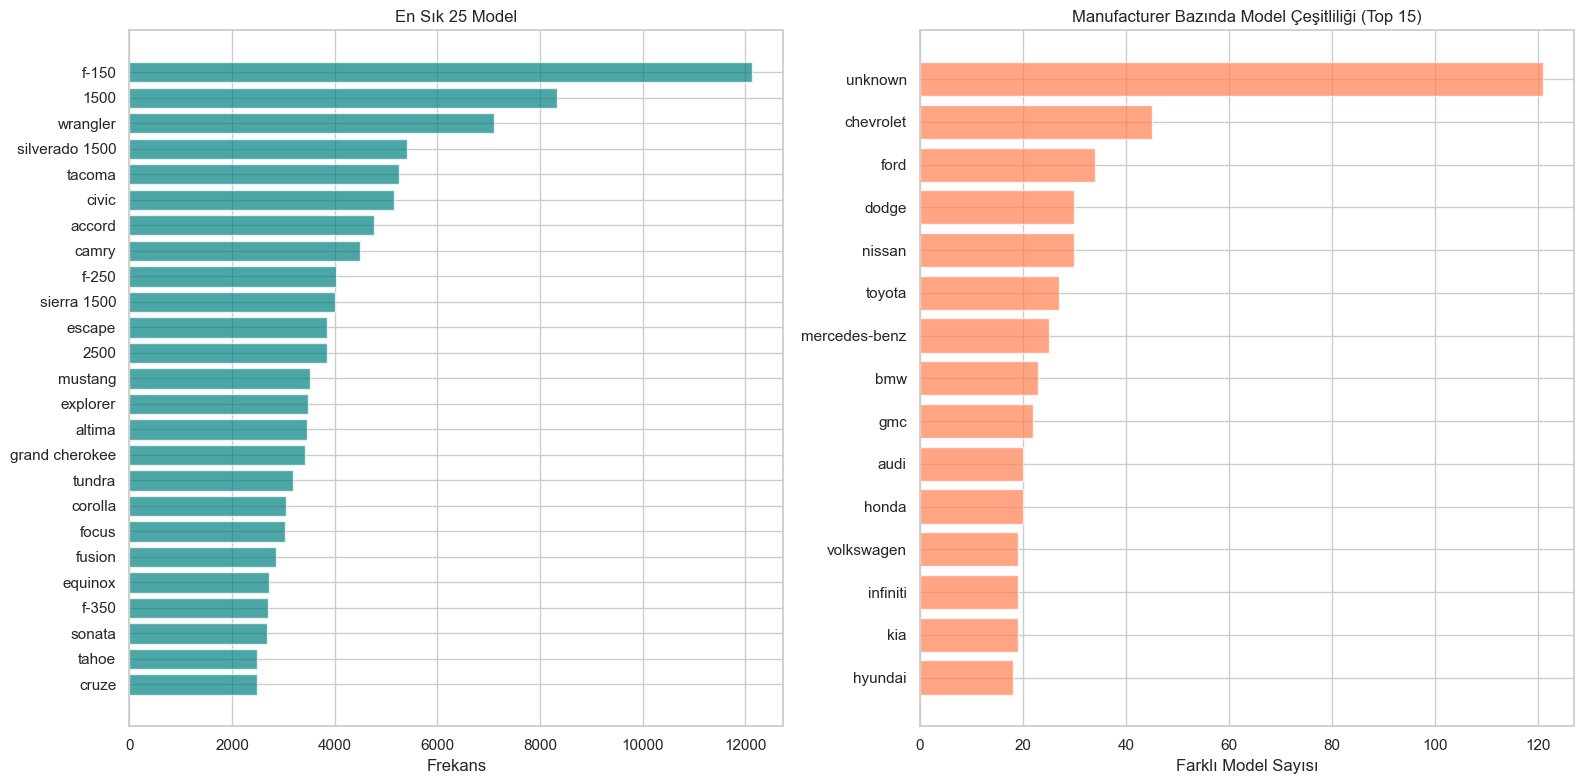


Toplam farklı model sayısı: 547
En sık model: f-150 (12,138 adet)


In [46]:
# MODEL DAĞILIMI GRAFİĞİ
print('='*60)
print('MODEL DAĞILIMI (URL\'den Çıkarma Sonrası)')
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. En sık 25 model
# Unknown hariç en sık 25 model
model_counts = df[df['model_normalized'] != 'unknown']['model_normalized'].value_counts().head(25)
axes[0].barh(model_counts.index, model_counts.values, color='teal', alpha=0.7)
axes[0].set_title('En Sık 25 Model')
axes[0].set_xlabel('Frekans')
axes[0].invert_yaxis()

# 2. Manufacturer bazında model çeşitliliği
model_variety = df.groupby('manufacturer')['model_normalized'].nunique().sort_values(ascending=False).head(15)
axes[1].barh(model_variety.index, model_variety.values, color='coral', alpha=0.7)
axes[1].set_title('Manufacturer Bazında Model Çeşitliliği (Top 15)')
axes[1].set_xlabel('Farklı Model Sayısı')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nToplam farklı model sayısı: {df['model_normalized'].nunique()}")
print(f"En sık model: {model_counts.index[0]} ({model_counts.values[0]:,} adet)")

## 3.2 Feature Importance Analizi

### Mutual Information Scores
Mutual Information (MI), iki değişken arasındaki **bağımlılığı** ölçen bilgi-teorik bir metriktir. 
- Non-linear ilişkileri yakalayabilir (korelasyonun aksine)
- Değer ≥ 0 (0 = bağımsız, büyük = güçlü ilişki)

### ANOVA F-test -> bu sadece kategorik sütun
ANOVA F-testi, **kategorik** feature'ların sürekli hedef değişken üzerindeki etkisini ölçer.
- Kategorik değişkenin farklı gruplarının fiyatı anlamlı şekilde farklılaştırıp farklılaştırmadığını test eder
- Yüksek F-score = güçlü ilişki

### f_regression
Numerik feature'lar için univariate(tek değişkenli) lineer regresyon testi.
- Her feature için F-değeri ve p-değeri hesaplar


MUTUAL INFORMATION SCORES

Mutual Information Scores (Yüksek = Güçlü İlişki):
         Feature  MI Score
        odometer  2.594530
model_normalized  0.934391
            year  0.625133
    manufacturer  0.401442
            type  0.300679
       condition  0.157134
       cylinders  0.143926
           drive  0.119894
            fuel  0.083260
    title_status  0.026956
    transmission  0.023800


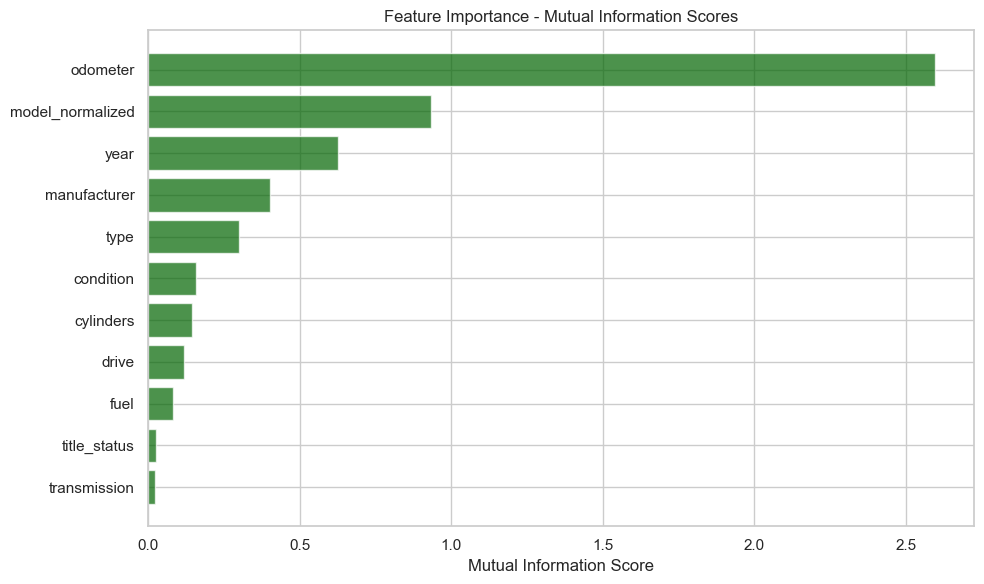

In [47]:
# MUTUAL INFORMATION SCORES
print('='*60)
print('MUTUAL INFORMATION SCORES')
print('='*60)

# Analiz için veri hazırlığı
analysis_df = df.copy()

# Kategorik kolonları encode edelim (MI hesabı için)
le_dict = {}
categorical_for_mi = ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type', "model_normalized"]

for col in categorical_for_mi:
    le = LabelEncoder()
    analysis_df[col + '_encoded'] = le.fit_transform(analysis_df[col].astype(str))
    le_dict[col] = le

# Tüm feature'ları birleştir
all_features_for_mi = ['year', 'cylinders', 'odometer'] + [col + '_encoded' for col in categorical_for_mi]
X_mi = analysis_df[all_features_for_mi].values
y_mi = analysis_df['price'].values

# Mutual Information hesapla
mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)

# Sonuçları DataFrame'e çevir
feature_names_mi = ['year', 'cylinders', 'odometer'] + categorical_for_mi
mi_df = pd.DataFrame({
    'Feature': feature_names_mi,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)

print('\nMutual Information Scores (Yüksek = Güçlü İlişki):')
print(mi_df.to_string(index=False))

# MI Scores görselleştirme
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color='darkgreen', alpha=0.7)
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance - Mutual Information Scores')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ANOVA F-TEST (Kategorik Feature'lar için)

ANOVA F-Test Sonuçları (Kategorik Features):
         Feature  F-Statistic  P-Value Significant (p<0.05)
           drive 12244.735955      0.0                  Yes
            fuel  9968.017834      0.0                  Yes
            type  4728.709371      0.0                  Yes
       condition  3202.736188      0.0                  Yes
    transmission  2051.597645      0.0                  Yes
    manufacturer  1186.955117      0.0                  Yes
    title_status   630.879337      0.0                  Yes
model_normalized   284.348876      0.0                  Yes


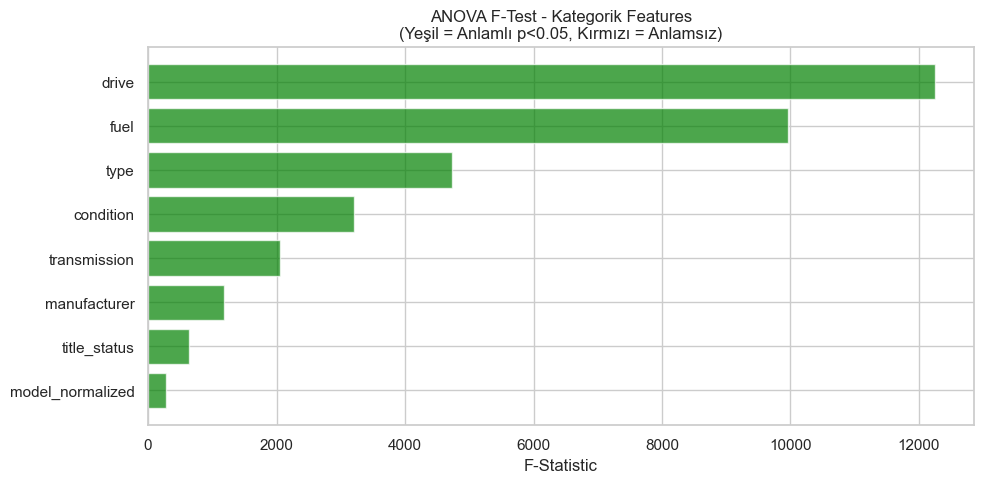

In [48]:
# ANOVA F-TEST (Kategorik Features için)
print('='*60)
print('ANOVA F-TEST (Kategorik Feature\'lar için)')
print('='*60)

from scipy import stats

anova_results = []
target = analysis_df['price']

for col in categorical_for_mi:
    groups = [group['price'].values for name, group in analysis_df.groupby(col)]
    # ANOVA F-test
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results.append({
        'Feature': col,
        'F-Statistic': f_stat,
        'P-Value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

anova_df = pd.DataFrame(anova_results).sort_values('F-Statistic', ascending=False)
print('\nANOVA F-Test Sonuçları (Kategorik Features):')
print(anova_df.to_string(index=False))

# F-Statistic görselleştirme
plt.figure(figsize=(10, 5))
colors = ['green' if p < 0.05 else 'red' for p in anova_df['P-Value']]
plt.barh(anova_df['Feature'], anova_df['F-Statistic'], color=colors, alpha=0.7)
plt.xlabel('F-Statistic')
plt.title('ANOVA F-Test - Kategorik Features\n(Yeşil = Anlamlı p<0.05, Kırmızı = Anlamsız)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


F-REGRESSION (Numerik Feature'lar için)

F-Regression Sonuçları (Numerik Features):
  Feature       F-Score  P-Value Significant (p<0.05)
     year 142032.483526      0.0                  Yes
 odometer 140990.608945      0.0                  Yes
cylinders  28633.401911      0.0                  Yes


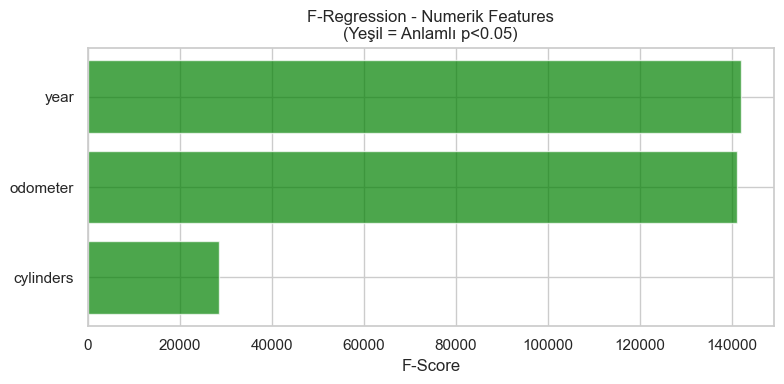

In [49]:
# F-REGRESSION (Numerik Features için)
print('='*60)
print('F-REGRESSION (Numerik Feature\'lar için)')
print('='*60)

# Numerik feature'lar
numeric_features_analysis = ['year', 'cylinders', 'odometer']
X_numeric = analysis_df[numeric_features_analysis].values
y_target = analysis_df['price'].values

# F-regression hesapla
f_scores, p_values = f_regression(X_numeric, y_target)

freg_df = pd.DataFrame({
    'Feature': numeric_features_analysis,
    'F-Score': f_scores,
    'P-Value': p_values,
    'Significant (p<0.05)': ['Yes' if p < 0.05 else 'No' for p in p_values]
}).sort_values('F-Score', ascending=False)

print('\nF-Regression Sonuçları (Numerik Features):')
print(freg_df.to_string(index=False))

# F-Score görselleştirme
plt.figure(figsize=(8, 4))
colors = ['green' if p < 0.05 else 'red' for p in freg_df['P-Value']]
plt.barh(freg_df['Feature'], freg_df['F-Score'], color=colors, alpha=0.7)
plt.xlabel('F-Score')
plt.title('F-Regression - Numerik Features\n(Yeşil = Anlamlı p<0.05)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE KARŞILAŞTIRMA ÖZETİ

--- NUMERIK FEATURES ---
Feature      Korelasyon   MI Score     F-Score        
--------------------------------------------------
year         0.5247       0.6251       142032.5       
cylinders    0.2667       0.1439       28633.4        
odometer     -0.5233      2.5945       140990.6       

--- KATEGORIK FEATURES ---
Feature         MI Score     ANOVA F-Stat   
---------------------------------------------
manufacturer    0.4014       1187.0         
condition       0.1571       3202.7         
fuel            0.0833       9968.0         
title_status    0.0270       630.9          
transmission    0.0238       2051.6         
drive           0.1199       12244.7        
type            0.3007       4728.7         
model_normalized 0.9344       284.3          

--- GENEL FEATURE RANKING (MI Score Bazlı) ---
         Feature  MI Score
        odometer  2.594530
model_normalized  0.934391
            year  0.625133
    manufacturer  0.401442
 

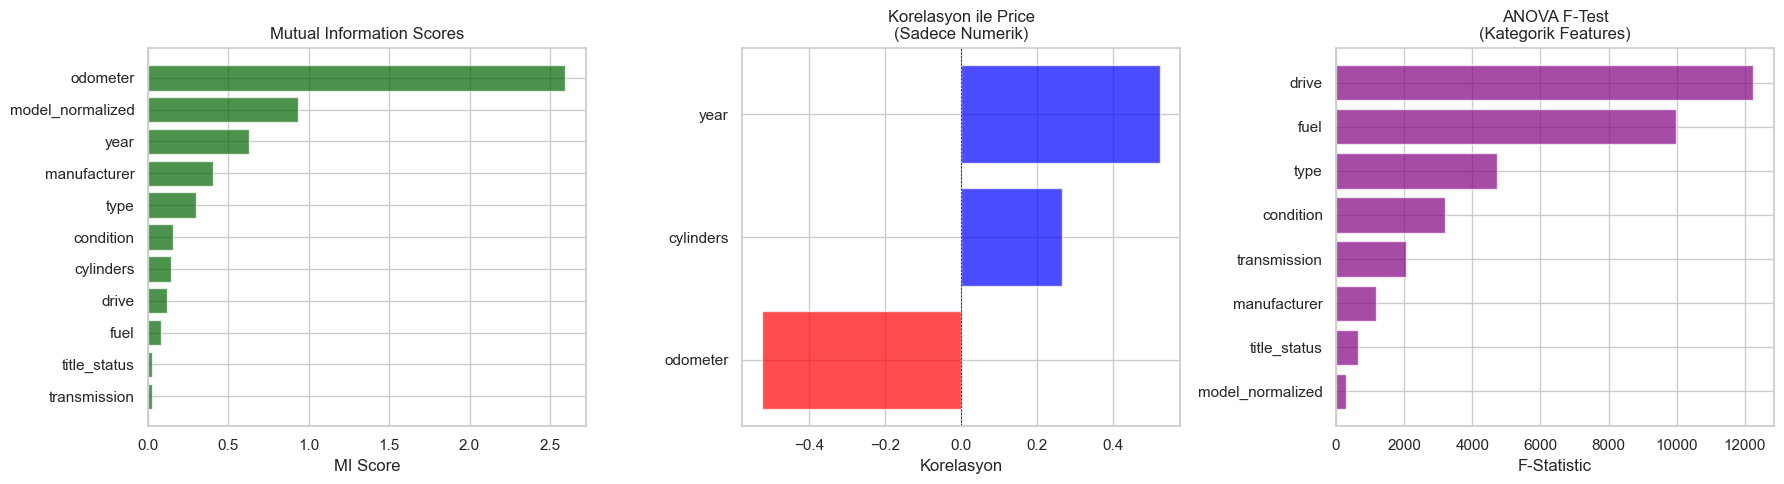


 YORUM:
- Yüksek MI Score: Feature, fiyatı tahmin etmede bilgi sağlıyor (linear/non-linear)
- Yüksek Korelasyon: Feature ile fiyat arasında güçlü lineer ilişki var
- Yüksek F-Statistic: Kategorik gruplar arasında anlamlı fiyat farkları var


In [50]:
# FEATURE IMPORTANCE KARSILASTIRMA OZETI
print('='*60)
print('FEATURE IMPORTANCE KARŞILAŞTIRMA ÖZETİ')
print('='*60)

# Korelasyon (sadece numerik için)
corr_with_price = analysis_df[['year', 'cylinders', 'odometer', 'price']].corr()['price'].drop('price')

# Özet tablo
print('\n--- NUMERIK FEATURES ---')
print(f'{"Feature":<12} {"Korelasyon":<12} {"MI Score":<12} {"F-Score":<15}')
print('-'*50)
for feat in ['year', 'cylinders', 'odometer']:
    corr_val = corr_with_price[feat]
    mi_val = mi_df[mi_df['Feature'] == feat]['MI Score'].values[0]
    f_val = freg_df[freg_df['Feature'] == feat]['F-Score'].values[0]
    print(f'{feat:<12} {corr_val:<12.4f} {mi_val:<12.4f} {f_val:<15.1f}')

print('\n--- KATEGORIK FEATURES ---')
print(f'{"Feature":<15} {"MI Score":<12} {"ANOVA F-Stat":<15}')
print('-'*45)
for feat in categorical_for_mi:
    mi_val = mi_df[mi_df['Feature'] == feat]['MI Score'].values[0]
    f_val = anova_df[anova_df['Feature'] == feat]['F-Statistic'].values[0]
    print(f'{feat:<15} {mi_val:<12.4f} {f_val:<15.1f}')

# Genel Feature Ranking (MI bazlı)
print('\n--- GENEL FEATURE RANKING (MI Score Bazlı) ---')
print(mi_df.to_string(index=False))

# Karşılaştırma grafiği
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) MI Scores
mi_sorted = mi_df.sort_values('MI Score', ascending=True)
axes[0].barh(mi_sorted['Feature'], mi_sorted['MI Score'], color='darkgreen', alpha=0.7)
axes[0].set_xlabel('MI Score')
axes[0].set_title('Mutual Information Scores')

# 2) Korelasyon (Numerik)
corr_sorted = corr_with_price.sort_values()
colors_corr = ['red' if v < 0 else 'blue' for v in corr_sorted]
axes[1].barh(corr_sorted.index, corr_sorted.values, color=colors_corr, alpha=0.7)
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_xlabel('Korelasyon')
axes[1].set_title('Korelasyon ile Price\n(Sadece Numerik)')

# 3) ANOVA F-Stat (Kategorik)
anova_sorted = anova_df.sort_values('F-Statistic', ascending=True)
axes[2].barh(anova_sorted['Feature'], anova_sorted['F-Statistic'], color='purple', alpha=0.7)
axes[2].set_xlabel('F-Statistic')
axes[2].set_title('ANOVA F-Test\n(Kategorik Features)')

plt.tight_layout()
plt.show()

print('\n YORUM:')
print('- Yüksek MI Score: Feature, fiyatı tahmin etmede bilgi sağlıyor (linear/non-linear)')
print('- Yüksek Korelasyon: Feature ile fiyat arasında güçlü lineer ilişki var')
print('- Yüksek F-Statistic: Kategorik gruplar arasında anlamlı fiyat farkları var')


## 4. Feature Selection (Ozellik Secimi)

**Cikarilan kolonlar:**
- `lat`, `long` - Price ile dusuk korelasyon
- `region` - 404 unique deger (cok fazla)
- `VIN`, `url`, `image_url` vb. - Model icin gereksiz


KORELASYON ANALIZI


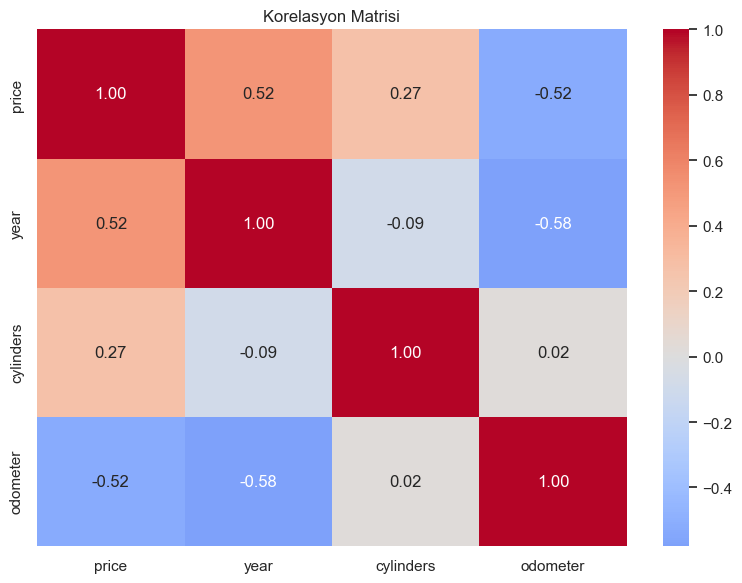


Price ile korelasyonlar:
price        1.000000
year         0.524675
cylinders    0.266702
odometer    -0.523276
Name: price, dtype: float64


In [51]:
# Korelasyon Analizi
print('='*60)
print('KORELASYON ANALIZI')
print('='*60)

numeric_cols = ['price', 'year', 'cylinders', 'odometer']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korelasyon Matrisi')
plt.tight_layout()
plt.show()

print('\nPrice ile korelasyonlar:')
print(corr_matrix['price'].sort_values(ascending=False))


## 5. Feature Engineering


## 5. TRAIN-TEST SPLIT

**ÖNEMLİ:** Data leakage önlemi için split işlemi feature engineering'den ÖNCE yapılıyor.
Feature engineering train ve test setleri üzerinde AYRI AYRI yapılacak.


In [52]:
# Feature ve Target ayirma
X = df.drop('price', axis=1)
y = df['price']  # Log transform şimdilik yok, feature eng. sonrası

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('='*60)
print('TRAIN/TEST SPLIT')
print('='*60)
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'Ortalama fiyat ($): Train=${y_train.mean():,.0f}, Test=${y_test.mean():,.0f}')
print('\n⚠️ NOT: Feature engineering train ve test üzerinde AYRI yapılacak (data leakage önlemi)')


TRAIN/TEST SPLIT
X_train: (299135, 15)
X_test:  (74784, 15)
Ortalama fiyat ($): Train=$19,363, Test=$19,485

⚠️ NOT: Feature engineering train ve test üzerinde AYRI yapılacak (data leakage önlemi)


## 6. FEATURE ENGINEERING (Split Sonrası)

**Data Leakage Önlemi:** Tüm feature engineering işlemleri train ve test setleri üzerinde AYRI yapılacak.

**Oluşturulacak Feature'lar:**
1. car_age - Arabanın yaşı
2. mil_per_year - Yıllık kilometre
3. condition_score - Condition numeric skoru (YENİ!)
4. depreciation_rate - Yıllık değer kaybı (YENİ!)
5. luxury_brand - Lüks marka flag (YENİ!)
6. electric_vehicle - Elektrikli araç flag (YENİ!)
7. high_mileage - Yüksek km flag (YENİ!)


In [53]:
# Feature Engineering (Train ve Test AYRI)
print('='*60)
print('FEATURE ENGINEERING (Data Leakage Önlemeli)')
print('='*60)

CURRENT_YEAR = datetime.now().year

# Kopyalar oluştur
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()
y_train_fe = y_train.copy()
y_test_fe = y_test.copy()

# 1) CAR_AGE
print(f'\n1) CAR_AGE oluşturuluyor (year: {CURRENT_YEAR})...')
X_train_fe['car_age'] = CURRENT_YEAR - X_train_fe['year']
X_test_fe['car_age'] = CURRENT_YEAR - X_test_fe['year']
print(f'   ✓ Train mean: {X_train_fe["car_age"].mean():.1f} years')
print(f'   ✓ Test mean: {X_test_fe["car_age"].mean():.1f} years')

# 2) MIL_PER_YEAR
print(f'\n2) MIL_PER_YEAR oluşturuluyor...')
X_train_fe['mil_per_year'] = X_train_fe['odometer'] / X_train_fe['car_age'].replace(0, 1)
X_test_fe['mil_per_year'] = X_test_fe['odometer'] / X_test_fe['car_age'].replace(0, 1)
print(f'   ✓ Train mean: {X_train_fe["mil_per_year"].mean():,.0f} miles/year')
print(f'   ✓ Test mean: {X_test_fe["mil_per_year"].mean():,.0f} miles/year')

# 3) CONDITION düzeltme (km bazlı) - SADECE TRAIN'DEN ÖĞREN
print(f'\n3) CONDITION düzeltme (odometer bazlı)...')
def correct_condition(odometer):
    if odometer <= 10000: return 'new'
    elif odometer <= 50000: return 'like new'
    elif odometer <= 100000: return 'excellent'
    elif odometer <= 150000: return 'good'
    else: return 'fair'

X_train_fe['condition'] = X_train_fe['odometer'].apply(correct_condition)
X_test_fe['condition'] = X_test_fe['odometer'].apply(correct_condition)
print(f'   ✓ Condition düzeltildi (km bazlı)')

# 4) CONDITION_SCORE (YENİ!)
print(f'\n4) CONDITION_SCORE oluşturuluyor (YENİ!)...')
condition_map = {
    'salvage': 1,
    'fair': 2,
    'good': 3,
    'excellent': 4,
    'like new': 5,
    'new': 6
}
X_train_fe['condition_score'] = X_train_fe['condition'].map(condition_map)
X_test_fe['condition_score'] = X_test_fe['condition'].map(condition_map)
# Null'ları train median ile doldur
train_median_cond = X_train_fe['condition_score'].median()
X_train_fe['condition_score'] = X_train_fe['condition_score'].fillna(train_median_cond)
X_test_fe['condition_score'] = X_test_fe['condition_score'].fillna(train_median_cond)
print(f'   ✓ Train: min={X_train_fe["condition_score"].min()}, max={X_train_fe["condition_score"].max()}')

# 5) DEPRECIATION_RATE (YENİ! - SADECE TRAIN'DEN ÖĞREN)
print(f'\n5) DEPRECIATION_RATE oluşturuluyor (YENİ!)...')
print(f'   → SADECE TRAIN setinden yeni araba fiyatları öğreniliyor')

# Train'deki yeni arabalar (son 2 yıl)
recent_mask_train = X_train_fe['year'] >= (CURRENT_YEAR - 2)
recent_cars_train = X_train_fe[recent_mask_train].copy()
recent_cars_train['price_temp'] = y_train_fe[recent_mask_train]

if len(recent_cars_train) > 0:
    # Manufacturer bazında ortalama yeni fiyat (SADECE TRAIN)
    avg_new_price_train = recent_cars_train.groupby('manufacturer')['price_temp'].mean().to_dict()
    overall_avg_train = recent_cars_train['price_temp'].mean()
else:
    avg_new_price_train = {}
    overall_avg_train = y_train_fe.mean()

# Train'e uygula
X_train_fe['expected_new_price'] = X_train_fe['manufacturer'].map(avg_new_price_train)
X_train_fe['expected_new_price'] = X_train_fe['expected_new_price'].fillna(overall_avg_train)
X_train_fe['depreciation_rate'] = (X_train_fe['expected_new_price'] - y_train_fe.values) / (X_train_fe['car_age'] + 1)
X_train_fe['depreciation_rate'] = X_train_fe['depreciation_rate'].clip(lower=0)

# Test'e AYNI kuralları uygula
X_test_fe['expected_new_price'] = X_test_fe['manufacturer'].map(avg_new_price_train)
X_test_fe['expected_new_price'] = X_test_fe['expected_new_price'].fillna(overall_avg_train)
X_test_fe['depreciation_rate'] = (X_test_fe['expected_new_price'] - y_test_fe.values) / (X_test_fe['car_age'] + 1)
X_test_fe['depreciation_rate'] = X_test_fe['depreciation_rate'].clip(lower=0)

# Geçici kolonu sil
X_train_fe = X_train_fe.drop(columns=['expected_new_price'])
X_test_fe = X_test_fe.drop(columns=['expected_new_price'])

print(f'   ✓ Train depreciation mean: ${X_train_fe["depreciation_rate"].mean():,.0f}/year')
print(f'   ✓ Test depreciation mean: ${X_test_fe["depreciation_rate"].mean():,.0f}/year')

# 6) LUXURY_BRAND (YENİ!)
print(f'\n6) LUXURY_BRAND oluşturuluyor (YENİ!)...')
luxury_brands = ['ferrari', 'lamborghini', 'bentley', 'rolls-royce', 'aston-martin',
                 'maserati', 'mclaren', 'porsche', 'bugatti', 'lotus']
X_train_fe['luxury_brand'] = X_train_fe['manufacturer'].str.lower().isin(luxury_brands).astype(int)
X_test_fe['luxury_brand'] = X_test_fe['manufacturer'].str.lower().isin(luxury_brands).astype(int)
print(f'   ✓ Train luxury: {X_train_fe["luxury_brand"].sum()} ({X_train_fe["luxury_brand"].mean()*100:.2f}%)')
print(f'   ✓ Test luxury: {X_test_fe["luxury_brand"].sum()} ({X_test_fe["luxury_brand"].mean()*100:.2f}%)')

# 7) ELECTRIC_VEHICLE (YENİ!)
print(f'\n7) ELECTRIC_VEHICLE oluşturuluyor (YENİ!)...')
X_train_fe['electric_vehicle'] = (X_train_fe['fuel'] == 'electric').astype(int)
X_test_fe['electric_vehicle'] = (X_test_fe['fuel'] == 'electric').astype(int)
print(f'   ✓ Train electric: {X_train_fe["electric_vehicle"].sum()} ({X_train_fe["electric_vehicle"].mean()*100:.2f}%)')
print(f'   ✓ Test electric: {X_test_fe["electric_vehicle"].sum()} ({X_test_fe["electric_vehicle"].mean()*100:.2f}%)')

# 8) HIGH_MILEAGE (YENİ!)
print(f'\n8) HIGH_MILEAGE oluşturuluyor (YENİ!)...')
high_mileage_threshold = 150000
X_train_fe['high_mileage'] = (X_train_fe['odometer'] > high_mileage_threshold).astype(int)
X_test_fe['high_mileage'] = (X_test_fe['odometer'] > high_mileage_threshold).astype(int)
print(f'   ✓ Train high mileage: {X_train_fe["high_mileage"].sum()} ({X_train_fe["high_mileage"].mean()*100:.2f}%)')
print(f'   ✓ Test high mileage: {X_test_fe["high_mileage"].sum()} ({X_test_fe["high_mileage"].mean()*100:.2f}%)')

# 9) Year kolonunu çıkar (car_age var)
print(f'\n9) YEAR kolonu çıkarılıyor...')
X_train_fe = X_train_fe.drop(columns=['year'])
X_test_fe = X_test_fe.drop(columns=['year'])
print(f'   ✓ Year kolonu silindi')

# 10) Log transform (target)
print(f'\n10) TARGET log transform...')
y_train_log = np.log1p(y_train_fe)
y_test_log = np.log1p(y_test_fe)
print(f'   ✓ Log transform uygulandı')

# Final veriyi güncelle
X_train = X_train_fe
X_test = X_test_fe
y_train = y_train_log
y_test = y_test_log

print(f'\n{'='*60}')
print(f'✓ FEATURE ENGINEERING TAMAMLANDI!')
print(f'{'='*60}')
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')
print(f'\nYeni eklenen feature lar:')
print(f'  → condition_score, depreciation_rate (Alperv3_Pro dan)')
print(f'  → luxury_brand, electric_vehicle, high_mileage (Alperv3_Pro dan)')
print(f'\nFinal kolonlar ({len(X_train.columns)}):')
print(list(X_train.columns))


FEATURE ENGINEERING (Data Leakage Önlemeli)

1) CAR_AGE oluşturuluyor (year: 2026)...
   ✓ Train mean: 14.0 years
   ✓ Test mean: 13.9 years

2) MIL_PER_YEAR oluşturuluyor...
   ✓ Train mean: 6,454 miles/year
   ✓ Test mean: 6,405 miles/year

3) CONDITION düzeltme (odometer bazlı)...
   ✓ Condition düzeltildi (km bazlı)

4) CONDITION_SCORE oluşturuluyor (YENİ!)...
   ✓ Train: min=2, max=6

5) DEPRECIATION_RATE oluşturuluyor (YENİ!)...
   → SADECE TRAIN setinden yeni araba fiyatları öğreniliyor
   ✓ Train depreciation mean: $337/year
   ✓ Test depreciation mean: $335/year

6) LUXURY_BRAND oluşturuluyor (YENİ!)...
   ✓ Train luxury: 1107 (0.37%)
   ✓ Test luxury: 236 (0.32%)

7) ELECTRIC_VEHICLE oluşturuluyor (YENİ!)...
   ✓ Train electric: 1281 (0.43%)
   ✓ Test electric: 307 (0.41%)

8) HIGH_MILEAGE oluşturuluyor (YENİ!)...
   ✓ Train high mileage: 55633 (18.60%)
   ✓ Test high mileage: 13673 (18.28%)

9) YEAR kolonu çıkarılıyor...
   ✓ Year kolonu silindi

10) TARGET log transform...


## 7. PREPROCESSOR TANIMLAMA


In [54]:
# Feature gruplari ve Preprocessor tanimlari
numeric_features = ['cylinders', 'odometer', 'car_age', 'mil_per_year', 'condition_score', 
                   'depreciation_rate', 'luxury_brand', 'electric_vehicle', 'high_mileage']

ordinal_features = ['condition', 'title_status']
ordinal_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],
    ['parts only', 'missing', 'salvage', 'lien', 'rebuilt', 'clean']
]

nominal_features = ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'model_normalized']

# Label Encoding Preprocessor (Decision Tree, KNN icin)
preprocessor_label = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('ord', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
    ('nom', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), nominal_features)
], remainder='drop')

print('Preprocessor tanimlandi')
print(f'Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'Ordinal features ({len(ordinal_features)}): {ordinal_features}')
print(f'Nominal features ({len(nominal_features)}): {nominal_features}')


Preprocessor tanimlandi
Numeric features (9): ['cylinders', 'odometer', 'car_age', 'mil_per_year', 'condition_score', 'depreciation_rate', 'luxury_brand', 'electric_vehicle', 'high_mileage']
Ordinal features (2): ['condition', 'title_status']
Nominal features (6): ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'model_normalized']


In [55]:
# ## 6.1 PyTorch icin Veri Hazirlama
# PyTorch kutuphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, f_regression, f_classif

from sklearn.ensemble import HistGradientBoostingRegressor
# Device belirleme (GPU varsa GPU, yoksa CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('='*60)
print('PYTORCH VERI HAZIRLAMA')
print('='*60)
print(f'Device: {device}')
print(f'PyTorch Version: {torch.__version__}')

# Veriyi preprocessor ile transform et
X_train_processed = preprocessor_label.fit_transform(X_train)
X_test_processed = preprocessor_label.transform(X_test)

print(f'X_train_processed shape: {X_train_processed.shape}')
print(f'X_test_processed shape: {X_test_processed.shape}')

# Numpy array'leri PyTorch Tensor'larina donustur
X_train_tensor = torch.FloatTensor(X_train_processed).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_processed).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')

# DataLoader olustur
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Input boyutunu kaydet (model tanimlarken kullanilacak)
input_size = X_train_processed.shape[1]

print(f'Batch size: {batch_size}')
print(f'Train batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')
print(f'Input size (feature sayisi): {input_size}')

PYTORCH VERI HAZIRLAMA
Device: cuda
PyTorch Version: 2.7.1+cu118
X_train_processed shape: (299135, 17)
X_test_processed shape: (74784, 17)
X_train_tensor shape: torch.Size([299135, 17])
y_train_tensor shape: torch.Size([299135, 1])
Batch size: 1024
Train batches: 293
Test batches: 74
Input size (feature sayisi): 17


In [56]:
# Sonuçları saklamak için dictionary
results = {}

# Değerlendirme fonksiyonu
def evaluate_preds(y_true, y_pred, model_name):
    """Model performansını değerlendirir ve metrikleri döndürür"""
    y_true_real = np.expm1(y_true)
    y_pred_real = np.maximum(np.expm1(y_pred), 0)
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    
    print(f'{model_name}:')
    print(f'  R2:   {r2:.4f}')
    print(f'  RMSE: ${rmse:,.0f}')
    print(f'  MAE:  ${mae:,.0f}')
    
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae}

print('results ve evaluate_preds tanimlandi')

results ve evaluate_preds tanimlandi


## 7. Model Egitimi
Base modeller: Bagging KNN, CatBoost, Voting Ensemble

In [57]:
# ============================================================
# MODEL 1: Bagging KNN (Base)
# ============================================================
from sklearn.ensemble import BaggingRegressor

print('='*60)
print('MODEL 1: Bagging KNN (Base)')
print('='*60)

bagging_base = BaggingRegressor(
    estimator=KNeighborsRegressor(n_neighbors=20, weights='distance', p=1, n_jobs=-1),
    n_estimators=15,
    max_samples=0.8,
    max_features=1.0,
    n_jobs=-1,
    random_state=42
)

start_time = time.time()
bagging_base.fit(X_train_processed, y_train)
y_pred_bag_base = bagging_base.predict(X_test_processed)
elapsed = time.time() - start_time

print(f'Egitim suresi: {elapsed:.1f} sn')
results['Bagging KNN (Base)'] = evaluate_preds(y_test, y_pred_bag_base, 'Bagging KNN (Base)')

MODEL 1: Bagging KNN (Base)
Egitim suresi: 486.3 sn
Bagging KNN (Base):
  R2:   0.9063
  RMSE: $4,627
  MAE:  $1,498


In [58]:
# ============================================================
# MODEL 2: CatBoost (Base)
# ============================================================
from catboost import CatBoostRegressor

print('='*60)
print('MODEL 2: CatBoost (Base)')
print('='*60)

catboost_base = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.05,
    depth=8,
    task_type='GPU',
    verbose=1000,
    random_state=42
)

start_time = time.time()
catboost_base.fit(X_train_processed, y_train)
y_pred_cat_base = catboost_base.predict(X_test_processed)
elapsed = time.time() - start_time

print(f'Egitim suresi: {elapsed:.1f} sn')
results['CatBoost (Base)'] = evaluate_preds(y_test, y_pred_cat_base, 'CatBoost (Base)')

MODEL 2: CatBoost (Base)
0:	learn: 0.8619244	total: 184ms	remaining: 15m 22s
1000:	learn: 0.1197368	total: 7.11s	remaining: 28.4s
2000:	learn: 0.1060435	total: 13.3s	remaining: 19.9s
3000:	learn: 0.0982085	total: 19.7s	remaining: 13.1s
4000:	learn: 0.0926054	total: 25.8s	remaining: 6.45s
4999:	learn: 0.0881955	total: 31.8s	remaining: 0us
Egitim suresi: 35.1 sn
CatBoost (Base):
  R2:   0.9867
  RMSE: $4,475
  MAE:  $1,501


In [59]:
# ============================================================
# MODEL 3: Voting Ensemble (Base) - Bagging KNN + CatBoost
# ============================================================
print('='*60)
print('MODEL 3: Voting Ensemble (Base)')
print('='*60)

y_pred_voting_base = 0.6 * y_pred_bag_base + 0.4 * y_pred_cat_base

results['Voting (Base)'] = evaluate_preds(y_test, y_pred_voting_base, 'Voting Ensemble (Base)')

MODEL 3: Voting Ensemble (Base)
Voting Ensemble (Base):
  R2:   0.9598
  RMSE: $4,261
  MAE:  $1,406


## 8. PCA Deneyi
Boyut indirgeme teknigi. CatBoost ile PCA kombinasyonu test edilecek.

In [60]:
# ============================================================
# MODEL 4: PCA + CatBoost
# ============================================================
print('='*60)
print('MODEL 4: PCA + CatBoost')
print('='*60)

# PCA için veriyi scale etmemiz gerekiyor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Aciklanan varyans orani: {sum(pca.explained_variance_ratio_):.4f}')

catboost_pca = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.05,
    depth=8,
    task_type='GPU',
    verbose=1000,
    random_state=42
)

start_time = time.time()
catboost_pca.fit(X_train_pca, y_train)
y_pred_pca = catboost_pca.predict(X_test_pca)
elapsed = time.time() - start_time

print(f'Egitim suresi: {elapsed:.1f} sn')
results['PCA + CatBoost'] = evaluate_preds(y_test, y_pred_pca, 'PCA + CatBoost')

# PCA etkisi karşılaştırması
fark_r2 = results['PCA + CatBoost']['R2'] - results['CatBoost (Base)']['R2']
print(f'\nPCA Etkisi (R2 Farki): {fark_r2:.4f}')
if fark_r2 < -0.01:
    print('Yorum: PCA performans kaybina yol acti.')
else:
    print('Yorum: PCA performansi korudu veya artirdi.')

MODEL 4: PCA + CatBoost
Aciklanan varyans orani: 0.8509
0:	learn: 0.8724880	total: 4.66ms	remaining: 23.3s
1000:	learn: 0.2378886	total: 6.04s	remaining: 24.1s
2000:	learn: 0.2009922	total: 11.5s	remaining: 17.2s
3000:	learn: 0.1802251	total: 17.5s	remaining: 11.6s
4000:	learn: 0.1663173	total: 23s	remaining: 5.75s
4999:	learn: 0.1559757	total: 28.9s	remaining: 0us
Egitim suresi: 30.6 sn
PCA + CatBoost:
  R2:   0.9552
  RMSE: $5,349
  MAE:  $2,233

PCA Etkisi (R2 Farki): -0.0315
Yorum: PCA performans kaybina yol acti.


## 9. Hyperparameter Tuning
Modelin parametrelerini en iyi sonucu verecek sekilde otomatik bulma islemi.

In [61]:
# ============================================================
# MODEL 5: Bagging KNN (Tuned)
# ============================================================
print('='*60)
print('MODEL 5: Bagging KNN - HYPERPARAMETER TUNING')
print('='*60)

param_grid_bag = {
    'n_estimators': [10, 15, 20, 25],
    'max_samples': [0.6, 0.7, 0.8, 1.0],
    'max_features': [0.8, 1.0]
}

base_knn = KNeighborsRegressor(n_neighbors=15, weights='distance', p=1, n_jobs=-1)

bagging_model = BaggingRegressor(
    estimator=base_knn,
    n_jobs=-1,
    random_state=42
)

print('RandomizedSearchCV basliyor...')
start_time = time.time()

search_bag = RandomizedSearchCV(
    bagging_model,
    param_grid_bag,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_bag.fit(X_train_processed, y_train)
elapsed = time.time() - start_time

print(f'\nTuning suresi: {elapsed:.1f} sn')
print(f'En iyi parametreler: {search_bag.best_params_}')

best_bagging = search_bag.best_estimator_
y_pred_bag_tuned = best_bagging.predict(X_test_processed)

results['Bagging KNN (Tuned)'] = evaluate_preds(y_test, y_pred_bag_tuned, 'Bagging KNN (Tuned)')
results['Bagging KNN (Tuned)']['best_params'] = search_bag.best_params_

MODEL 5: Bagging KNN - HYPERPARAMETER TUNING
RandomizedSearchCV basliyor...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tuning suresi: 5385.3 sn
En iyi parametreler: {'n_estimators': 25, 'max_samples': 1.0, 'max_features': 0.8}
Bagging KNN (Tuned):
  R2:   0.9420
  RMSE: $4,229
  MAE:  $1,201


In [62]:
# ============================================================
# MODEL 6: CatBoost (Tuned)
# ============================================================
print('='*60)
print('MODEL 6: CatBoost - HYPERPARAMETER TUNING')
print('='*60)

param_grid_cat = {
    'iterations': [5000, 7500, 10000],
    'learning_rate': [0.03, 0.05, 0.08],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5]
}

print('RandomizedSearchCV basliyor (bu biraz surebilir)...')
start_time = time.time()

catboost_tuning = CatBoostRegressor(
    task_type='GPU',
    verbose=0,
    random_state=42
)

search_cat = RandomizedSearchCV(
    catboost_tuning,
    param_grid_cat,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # CatBoost GPU için 1
    random_state=42,
    verbose=1
)

search_cat.fit(X_train_processed, y_train)
elapsed = time.time() - start_time

print(f'\nTuning suresi: {elapsed:.1f} sn')
print(f'En iyi parametreler: {search_cat.best_params_}')

best_catboost = search_cat.best_estimator_
y_pred_cat_tuned = best_catboost.predict(X_test_processed)

results['CatBoost (Tuned)'] = evaluate_preds(y_test, y_pred_cat_tuned, 'CatBoost (Tuned)')
results['CatBoost (Tuned)']['best_params'] = search_cat.best_params_

MODEL 6: CatBoost - HYPERPARAMETER TUNING
RandomizedSearchCV basliyor (bu biraz surebilir)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tuning suresi: 1174.7 sn
En iyi parametreler: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 7500, 'depth': 10}
CatBoost (Tuned):
  R2:   0.9890
  RMSE: $4,139
  MAE:  $1,227


In [63]:
# ============================================================
# MODEL 7: Voting Ensemble (Tuned) - Bagging KNN + CatBoost
# ============================================================
print('='*60)
print('MODEL 7: Voting Ensemble (Tuned)')
print('='*60)

y_pred_voting_tuned = 0.6 * y_pred_bag_tuned + 0.4 * y_pred_cat_tuned

results['Voting (Tuned)'] = evaluate_preds(y_test, y_pred_voting_tuned, 'Voting Ensemble (Tuned)')

MODEL 7: Voting Ensemble (Tuned)
Voting Ensemble (Tuned):
  R2:   0.9733
  RMSE: $4,030
  MAE:  $1,152


## 9. Model Karsilastirmasi


MODEL KARSILASTIRMASI
                           R2         RMSE          MAE
CatBoost (Tuned)     0.988980  4139.087244  1226.891811
CatBoost (Base)      0.986654  4474.673954  1501.054999
Voting (Tuned)       0.973324  4029.535267  1152.370052
Voting (Base)        0.959843  4261.277984  1406.340985
PCA + CatBoost       0.955151  5349.182394  2232.840072
Bagging KNN (Tuned)  0.941987  4228.527109  1201.491127
Bagging KNN (Base)   0.906252  4626.980101  1497.853040

EN IYI MODEL: CatBoost (Tuned)
  R2:   0.9890
  RMSE: $4,139


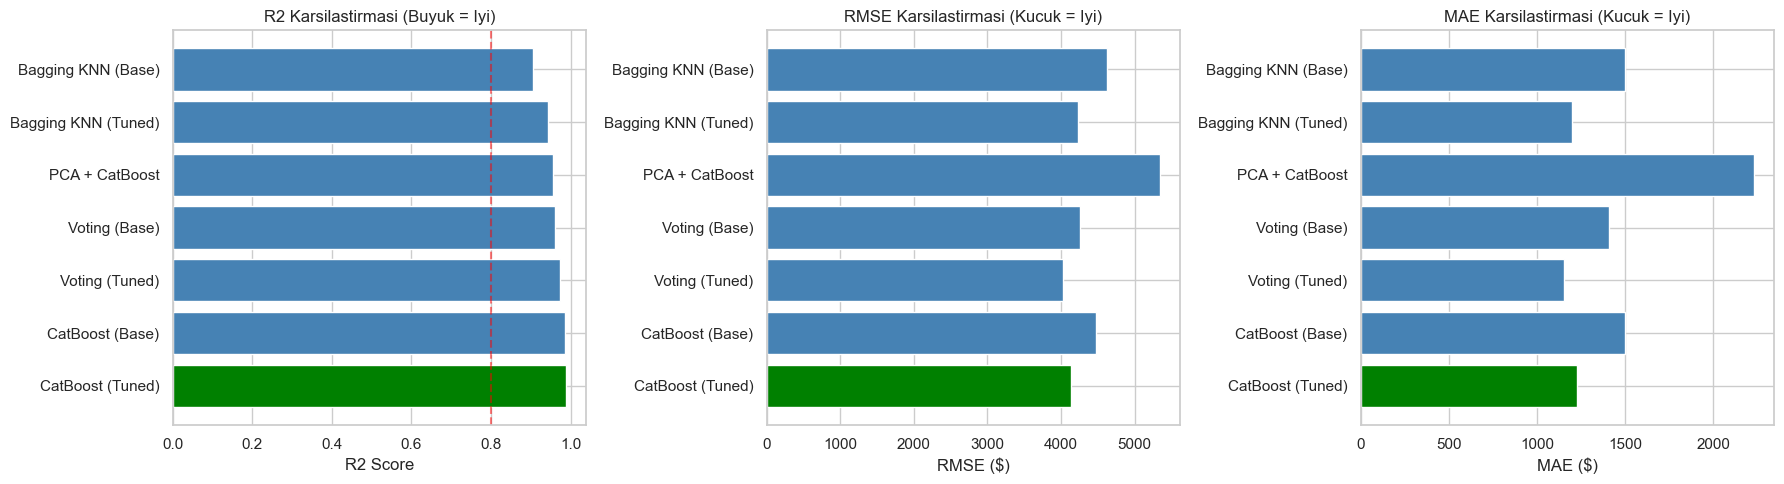

In [64]:
# ============================================================
# MODEL KARSILASTIRMASI
# ============================================================
print('='*60)
print('MODEL KARSILASTIRMASI')
print('='*60)

comparison_df = pd.DataFrame({
    name: {'R2': metrics['R2'], 'RMSE': metrics['RMSE'], 'MAE': metrics['MAE']}
    for name, metrics in results.items()
}).T.sort_values('R2', ascending=False)

print(comparison_df.to_string())

# En iyi model
best_model_name = comparison_df.index[0]
best_r2 = comparison_df.loc[best_model_name, 'R2']
best_rmse = comparison_df.loc[best_model_name, 'RMSE']

print(f'\n{"="*60}')
print(f'EN IYI MODEL: {best_model_name}')
print(f'  R2:   {best_r2:.4f}')
print(f'  RMSE: ${best_rmse:,.0f}')
print(f'{"="*60}')

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['green' if m == best_model_name else 'steelblue' for m in comparison_df.index]

# R2
axes[0].barh(comparison_df.index, comparison_df['R2'], color=colors)
axes[0].set_xlabel('R2 Score')
axes[0].set_title('R2 Karsilastirmasi (Buyuk = Iyi)')
axes[0].axvline(x=0.8, color='red', linestyle='--', alpha=0.5)

# RMSE
axes[1].barh(comparison_df.index, comparison_df['RMSE'], color=colors)
axes[1].set_xlabel('RMSE ($)')
axes[1].set_title('RMSE Karsilastirmasi (Kucuk = Iyi)')

# MAE
axes[2].barh(comparison_df.index, comparison_df['MAE'], color=colors)
axes[2].set_xlabel('MAE ($)')
axes[2].set_title('MAE Karsilastirmasi (Kucuk = Iyi)')

plt.tight_layout()
plt.show()

## catboost'un hangi featurelara önem verdiğini görmek için

FEATURE IMPORTANCE


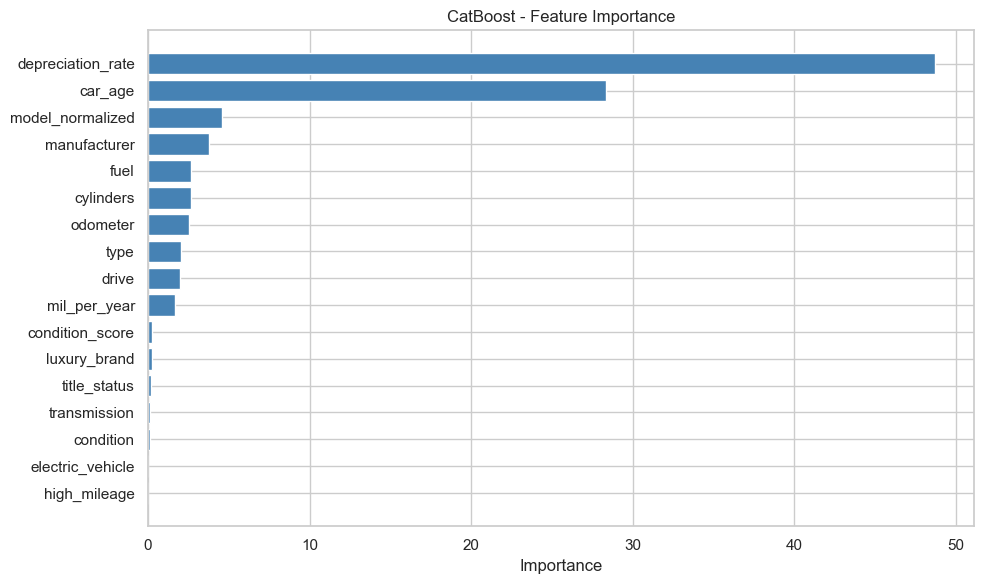


En önemli 5 feature:
          Feature  Importance
             fuel    2.681759
     manufacturer    3.768182
 model_normalized    4.551488
          car_age   28.374605
depreciation_rate   48.692791


In [65]:
# Feature Importance - CatBoost
print('='*60)
print('FEATURE IMPORTANCE')
print('='*60)

feature_names = numeric_features + ordinal_features + nominal_features
importances = best_catboost.feature_importances_

# DataFrame oluştur
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=True)

# Görselleştir
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('CatBoost - Feature Importance')
plt.tight_layout()
plt.show()

print('\nEn önemli 5 feature:')
print(importance_df.tail(5).to_string(index=False))


## 10. Validation Protokolu


In [ ]:
# Voting Ensemble için Manual Cross-Validation
from sklearn.model_selection import KFold

print('='*60)
print('VOTING ENSEMBLE - MANUAL CROSS-VALIDATION')
print('='*60)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
voting_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed), 1):
    # Fold verilerini ayır
    X_fold_train = X_train_processed[train_idx]
    X_fold_val = X_train_processed[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
 
    # Bagging KNN eğit (tuned değerleri ile eğitilcek o değerleri yukardaki sonuca göre girdim buraya)
    bag_fold = BaggingRegressor(
        estimator=KNeighborsRegressor(n_neighbors=15, weights='distance', p=1, n_jobs=-1),
        n_estimators=25,
        max_samples=1.0,
        max_features=0.8,
        n_jobs=-1,
        random_state=42
    )
    bag_fold.fit(X_fold_train, y_fold_train)
    y_pred_bag_fold = bag_fold.predict(X_fold_val)
   
    # CatBoost eğit (tuned değerleri ile eğitilcek o değerleri yukardaki sonuca göre girdim buraya)
    cat_fold = CatBoostRegressor(
        iterations=7500,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=5,
        verbose=0,
        random_state=42
    )
    cat_fold.fit(X_fold_train, y_fold_train)
    y_pred_cat_fold = cat_fold.predict(X_fold_val)
    
    # Voting
    y_pred_voting_fold = 0.6 * y_pred_bag_fold + 0.4 * y_pred_cat_fold
    
    # R2 hesapla
    fold_r2 = r2_score(y_fold_val, y_pred_voting_fold)
    voting_cv_scores.append(fold_r2)
    print(f'Fold {fold}: R2 = {fold_r2:.4f}')

print(f'\nOrtalama R2: {np.mean(voting_cv_scores):.4f} (+/- {np.std(voting_cv_scores):.4f})')

VOTING ENSEMBLE - MANUAL CROSS-VALIDATION


## 11. Hata Analizi (Residual Analysis)


In [ ]:
# ## 12. Hata Analizi (Residual Analysis)

print('\n' + '='*60)
print(f'HATA ANALİZİ - {best_model_name}')
print('='*60)

# En iyi modelin tahminlerini kullan (Voting Tuned)
y_true_real = np.expm1(y_test)
y_pred_best_real = np.maximum(np.expm1(y_pred_voting_tuned), 0)

residuals = y_true_real - y_pred_best_real

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Tahmin vs Gerçek
axes[0].scatter(y_true_real, y_pred_best_real, alpha=0.4, color='steelblue', s=10)
axes[0].plot([0, y_true_real.max()], [0, y_true_real.max()], 'r--', lw=2)
axes[0].set_xlabel('Gerçek Fiyat ($)')
axes[0].set_ylabel('Tahmin Edilen Fiyat ($)')
axes[0].set_title('Tahmin vs Gerçek')

# 2. Residual Dağılımı
sns.histplot(residuals, bins=50, kde=True, ax=axes[1], color='orange')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Hata Dağılımı (Residuals)')
axes[1].set_xlabel('Hata ($)')

# 3. Residual vs Tahmin (Heteroscedasticity Kontrolü)
axes[2].scatter(y_pred_best_real, residuals, alpha=0.4, color='green', s=10)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel('Tahmin Edilen Fiyat ($)')
axes[2].set_ylabel('Hata ($)')
axes[2].set_title('Residual vs Tahmin')

plt.tight_layout()
plt.show()

print("\nHata İstatistikleri:")
print(residuals.describe())

# Outlier Analizi
print('\n' + '='*60)
print('OUTLIER ANALİZİ')
print('='*60)

threshold = residuals.std() * 3  # 3 sigma kuralı
outliers_mask = np.abs(residuals) > threshold

print(f'Threshold (3 sigma): ${threshold:,.0f}')
print(f'Outlier sayısı: {outliers_mask.sum()} ({outliers_mask.sum()/len(residuals)*100:.2f}%)')

# Outlier istatistikleri
outlier_residuals = residuals[outliers_mask]
print(f'\nOutlier Hata Aralığı:')
print(f'  Min: ${outlier_residuals.min():,.0f}')
print(f'  Max: ${outlier_residuals.max():,.0f}')

# Görselleştirme
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_best_real[~outliers_mask], residuals[~outliers_mask], alpha=0.4, color='green', s=10, label='Normal')
plt.scatter(y_pred_best_real[outliers_mask], residuals[outliers_mask], alpha=0.6, color='red', s=20, label='Outlier')
plt.axhline(threshold, color='orange', linestyle='--', label=f'+3σ (${threshold:,.0f})')
plt.axhline(-threshold, color='orange', linestyle='--', label=f'-3σ (-${threshold:,.0f})')
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Tahmin Edilen Fiyat ($)')
plt.ylabel('Hata ($)')
plt.title('Outlier Analizi - Normal vs Outlier')
plt.legend()
plt.tight_layout()
plt.show()

print("\nProje Analizi Tamamlandı.")

In [ ]:
# Model Kaydetme
import joblib
joblib.dump({
    'bagging_model': best_bagging, 
    'catboost_model': best_catboost,
    'model_name': best_model_name, 
    'r2': best_r2, 
    'rmse': best_rmse
}, 'best_model_simplified.pkl')
print('Model kaydedildi: best_model_simplified.pkl')

## PROJE OZETI

### Kullanilan Modeller:
 **Bagging KNN:** KNN'in ensemble versiyonu, varyans azaltma
 **CatBoost:** Gradient boosting, kategorik verilerle iyi çalışır
 **Voting Ensemble:** Bagging KNN + CatBoost kombinasyonu, zaten en iyi sonucu da bu verdi.

### Encoding Stratejisi:
 Label Encoding (OrdinalEncoder) tüm modeller için

### Sonuc:
En iyi model ve performans metrikleri yukarida gosterilmistir.